# Abschnitt 1: Entwicklung des Modells

In [55]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split  
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score  
from sklearn.metrics import classification_report  
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, precision_score, fbeta_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from lime.lime_tabular import LimeTabularExplainer
!pip install lime

## Datenimport und erste Exploration

In [59]:
df = pd.read_csv("heart.csv")
df.head()

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Show information about column types and non-null counts
df.info()

# Print missing values for each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Set the target variable for classification
target = "HeartDisease"  # 1 = disease present, 0 = no disease

# Check uniqueness of the target values
print("\nTarget variable selected:", target)
print("Unique values in target:", df[target].unique())

Dataset shape: (918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR    

**Beobachtung:**
- Ausgabe der Datensatzgröße zur Einordnung des Umfangs (918 Beobachtungen, 12 Merkmale)
- Überprüfung der Datentypen und Nicht-Null-Werte aller Spalten zur Identifikation numerischer und kategorialer Features
- Analyse auf fehlende Werte zeigt, dass der Datensatz vollständig ist (keine Missing Values)
- Festlegung der Zielvariable `HeartDisease` für die binäre Klassifikation (0 = keine Erkrankung, 1 = Erkrankung vorhanden)
- Kontrolle der Zielvariable bestätigt ein binäres Klassifikationsproblem mit zwei Ausprägungen (0 und 1)

**Konsequenz:**  
Der Datensatz ist vollständig, sauber und direkt für die weitere Modellierung geeignet; eine Vorverarbeitung für fehlende Werte ist nicht erforderlich.


###

In [60]:
# Separate input features (X) and target labels (y)
X = df.drop(columns=[target])  # X = all columns except HeartDisease
y = df[target]                 # y = the HeartDisease column only

# Show basic information about the target distribution (class balance)
print("Target value counts (0 = no disease, 1 = disease):")
print(y.value_counts())

# Automatically detect numeric feature columns (int or float)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Automatically detect categorical feature columns (non-numeric types)
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nNumeric feature columns:")
print(numeric_features)

print("\nCategorical feature columns:")
print(categorical_features)

Target value counts (0 = no disease, 1 = disease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Numeric feature columns:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Categorical feature columns:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


**Beobachtung:**
- Trennung des Datensatzes in Eingangsmerkmale (`X`) und Zielvariable (`y`), wobei `HeartDisease` als Target definiert ist.
- Auszählung der Zielklassen ergibt 508 Fälle mit Herzkrankheit (1) und 410 Fälle ohne Herzkrankheit (0).
- Die Klassenverteilung ist leicht unausgewogen, jedoch ohne starke Dominanz einer Klasse.
- Numerische Features werden automatisch über ihre Datentypen identifiziert.
- Kategoriale Features werden automatisch über nicht-numerische Datentypen identifiziert.

**Konsequenz:**
- Es liegt eine moderate Klassenbalance vor. Ein explizites Over- oder Undersampling ist nicht zwingend erforderlich.
- Beim Train-Test-Split sollte eine Stratifizierung verwendet werden, um die Klassenverteilung beizubehalten.
- Die klare Trennung in numerische und kategoriale Features ermöglicht ein strukturiertes Preprocessing (z. B. Skalierung vs. Encoding) in späteren Modellpipelines.



## Train-, Validierungs- und Test-Split

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,      # 15% for final test
    random_state=42,
    stratify=y           # keep 0/1 ratio consistent
)

validation_ratio = 0.15 / 0.85  # ~0.17647

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=validation_ratio,  # produces 15% overall validation
    random_state=42,
    stratify=y_temp
)

# Print out the sizes to confirm 70/15/15 split
print("Train set size:     ", X_train.shape[0], "rows")
print("Validation set size:", X_val.shape[0], "rows")
print("Test set size:      ", X_test.shape[0], "rows")

# Print percentages
total = len(df)
print("\nPercentage breakdown:")
print("Train:      ", round(X_train.shape[0] / total * 100, 2), "%")
print("Validation: ", round(X_val.shape[0] / total * 100, 2), "%")
print("Test:       ", round(X_test.shape[0] / total * 100, 2), "%")

Train set size:      642 rows
Validation set size: 138 rows
Test set size:       138 rows

Percentage breakdown:
Train:       69.93 %
Validation:  15.03 %
Test:        15.03 %


**Beobachtung:**
- In beiden Split-Schritten wird `stratify` verwendet, um die Klassenverteilung beizubehalten.
- Die resultierende Aufteilung beträgt ca. 70 % Training, 15 % Validierung und 15 % Test.

**Konsequenz:**
- Saubere und faire Modellbewertung durch klar getrennte, stratifizierte Datenaufteilung ohne Informationsleckage.



## Preprocessing: One-Hot-Encoding und Feature-Zusammenführung

In [5]:
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False  # Wichtig: False, damit wir eine lesbare Tabelle (Matrix) bekommen
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features), 
        ("cat", categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False # Sorgt für schönere Namen ohne "num__" oder "cat__" Präfix
)


# fit() darf NUR auf X_train passieren
# Lernen (fit) und Anwenden (transform) auf Trainingsdaten
X_train_np = preprocessor.fit_transform(X_train)

# Nur Anwenden (transform) auf Validierungsdaten (nichts neues lernen)
X_val_np = preprocessor.transform(X_val)

# Nur Anwenden (transform) auf Testdaten
X_test_np = preprocessor.transform(X_test)

# Holen Feature-Namen der neuen Spalten direkt aus dem Preprocessor
feature_names = preprocessor.get_feature_names_out()


X_train_processed = pd.DataFrame(X_train_np, columns=feature_names, index=X_train.index)
X_val_processed = pd.DataFrame(X_val_np, columns=feature_names, index=X_val.index)
X_test_processed = pd.DataFrame(X_test_np, columns=feature_names, index=X_test.index)

print(f"Neue Anzahl Features nach Preprocessing: {X_train_processed.shape[1]}")
print("\nSo sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):")
display(X_train_processed.head(3))

Neue Anzahl Features nach Preprocessing: 20

So sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):


Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
43   52.0      140.0        259.0        0.0  170.0      0.0    0.0    1.0   
760  53.0      123.0        282.0        0.0   95.0      2.0    0.0    1.0   
255  53.0      120.0        274.0        0.0  130.0      0.0    1.0    0.0   

     ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
43                 0.0                0.0                1.0   
760                1.0                0.0                0.0   
255                0.0                0.0                1.0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
43                0.0             0.0                0.0            1.0   
760               0.0             0.0                1.0            0.0   
255               0.0             0.0                1.0            0.0   

     ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  \
43                1.0               0.0            0.0            0.0   
760               0.0               1.0            0.0            1.0   
255               1.0               0.0            0.0            0.0   

     ST_Slope_Up  
43           1.0  
760          0.0  
255          1.0

**Beobachtung:**
- Für kategoriale Features wird ein `OneHotEncoder` verwendet, der unbekannte Kategorien ignoriert.
- Das Encoding wird so konfiguriert, dass eine dichte Matrix (`sparse_output=False`) erzeugt wird.
- Numerische Features werden unverändert durchgereicht (`passthrough`).
- Beide Feature-Typen werden über einen `ColumnTransformer` zu einer gemeinsamen Feature-Matrix kombiniert.
- Der Preprocessor wird ausschließlich auf den Trainingsdaten gefittet und anschließend auf Validierungs- und Testdaten angewendet.
- Nach dem Preprocessing steigt die Anzahl der Features von ursprünglich 11 auf 20.
- Die transformierten Daten werden wieder in Pandas DataFrames mit sprechenden Feature-Namen überführt.

**Konsequenz:**
- Alle kategorialen Variablen liegen nun in numerischer Form vor und sind modellkompatibel.
- Durch das Fitten nur auf den Trainingsdaten wird Data Leakage vermieden.
- Einheitliche Feature-Strukturen in Train-, Validierungs- und Testset ermöglichen eine konsistente Modellierung.
- Die expliziten Feature-Namen bilden eine wichtige Grundlage für spätere Interpretierbarkeit und XAI-Analysen.


## Training eines Random-Forest-Modells

In [6]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,   # Die Bäume wachsen, bis alle Blätter rein sind
    random_state=40,
    n_jobs=-1         # Nutzt alle verfügbaren CPU-Kerne für schnelleres Training
)

# Wir nutzen weiterhin die vorverarbeiteten Daten (X_train_processed)
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=40)

**Beobachtung:**
- Initialisierung eines `RandomForestClassifier` mit 100 Entscheidungsbäumen.
- Ein fester `random_state` wird verwendet, um Reproduzierbarkeit sicherzustellen.
- Das Modell wird auf den vollständig vorverarbeiteten Trainingsdaten (`X_train_processed`) trainiert.

**Konsequenz:**
- Modell, welches komplexe, nichtlineare Zusammenhänge in den Daten lernen kann.

## Validierung mit Fokus auf F2-Score

In [7]:
y_val_pred = rf_model.predict(X_val_processed)

# Metriken mit Fokus auf F2-Score (positve Klasse = 1)
recall = recall_score(y_val, y_val_pred, pos_label=1)
precision = precision_score(y_val, y_val_pred, pos_label=1)
accuracy = accuracy_score(y_val, y_val_pred)
f2 = fbeta_score(y_val, y_val_pred, beta=2, pos_label=1)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision (pos=1): {precision:.4f}")
print(f"Validation Recall (pos=1): {recall:.4f}")
print(f"Validation F2-Score (pos=1): {f2:.4f}")

Validation Accuracy: 0.8551
Validation Precision (pos=1): 0.8684
Validation Recall (pos=1): 0.8684
Validation F2-Score (pos=1): 0.8684


**Beobachtung:**
- Das Random-Forest-Modell wird auf dem Validierungsdatensatz ausgewertet.
- Precision und Recall für die positive Klasse (HeartDisease = 1) sind identisch und hoch.
- Der F2-Score entspricht dem Wert von Precision und Recall.
- Accuracy liegt bei ca. 0.86.

**Konsequenz:**
- Das Modell erkennt einen Großteil der tatsächlich erkrankten Personen zuverlässig.
- Der hohe F2-Score bestätigt eine gute Performance unter stärkerer Gewichtung des Recall.

## Evaluation auf dem Testdatensatz mit Fokus auf F2-Score

In [8]:
y_test_pred = rf_model.predict(X_test_processed)

# Metriken mit Fokus auf F2-Score (positive Klasse = 1)
test_recall = recall_score(y_test, y_test_pred, pos_label=1)
test_precision = precision_score(y_test, y_test_pred, pos_label=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2, pos_label=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (pos=1): {test_precision:.4f}")
print(f"Test Recall (pos=1): {test_recall:.4f}")
print(f"Test F2-Score (pos=1): {test_f2:.4f}")

Test Accuracy: 0.8986
Test Precision (pos=1): 0.8974
Test Recall (pos=1): 0.9211
Test F2-Score (pos=1): 0.9162


**Beobachtung:**
- Das Random-Forest-Modell wird auf dem zuvor unangetasteten Testdatensatz evaluiert.
- Precision für die positive Klasse ist hoch, während der Recall noch höher ausfällt.
- Der F2-Score liegt nahe am Recall-Wert und ist höher als Precision.
- Die Test-Accuracy liegt bei ca. 0.90.

**Konsequenz:**
- Das Modell erkennt den Großteil der tatsächlich erkrankten Personen korrekt.
- Die stärkere Gewichtung des Recall im F2-Score bestätigt die Eignung des Modells für medizinisch motivierte Anwendungsfälle.
- Die höhere Testleistung im Vergleich zur Validierung deutet auf eine gute Generalisierungsfähigkeit hin.
- Das Modell stellt eine stabile und belastbare Grundlage für nachfolgende XAI-Analysen dar.

---

# Abschnitt 2: XAI-Analyse

## Ziel des Projektes

Ziel des Projekts ist es, zu verstehen, wie ein Random-Forest-Modell Entscheidungen zur Herzkrankheit trifft (global & lokal) und dieses Verständnis zu nutzen, um die Modellleistung gezielt zu verbessern.

## Projektstruktur (High-Level)

| Phase | Ziel                           |
| ----- | ------------------------------ |
| 1     | Datensatz & Problemstellung    |
| 2     | Wahl der zentralen Metrik      |
| 3     | Baseline-Modell verstehen      |
| 4     | Globales XAI                   |
| 5     | Lokales XAI                    |
| 6     | Erkenntnisse → Modellanpassung |
| 7     | Vorher–Nachher-Vergleich       |
| 8     | Fazit                          |

---

# Phase 1: Datensatz & Problemstellung


## Problemstellung

Wir verwenden das **Heart Disease Dataset (Kaggle)**. Ziel ist eine **binäre Klassifikation**, bei der vorhergesagt wird, ob bei einer Person ein Hinweis auf eine Herzkrankheit vorliegt. Dabei ist besonders relevant, **welche Personen als krank erkannt werden** und **welche fälschlicherweise übersehen werden**.


## Zielvariable

- **`HeartDisease`**
  - `0` → kein Hinweis auf Herzkrankheit
  - `1` → Hinweis auf Herzkrankheit


## Zielsetzung des Projekts

Dieses Projekt verfolgt **zwei zentrale Ziele**:

### 1) Technisches Ziel: Modellleistung verbessern

- Analyse eines Random-Forest-Modells zur Herzkrankheitsvorhersage
- Fokus auf die Reduktion kritischer Fehlklassifikationen
- Gezielte Verbesserung der Modellleistung anhand des **F2-Scores**
  (starke Gewichtung von Recall, ohne Precision vollständig zu ignorieren)


### 2) Inhaltliches Ziel: Modellentscheidungen verständlich machen

Neben der reinen Leistungsoptimierung soll das Modell **erklärbar** gemacht werden:

- Verständnis, **warum** das Modell bestimmte Personen als krank oder gesund einstuft
- Transparente Darstellung der entscheidenden Merkmale
- Unterstützung von **nicht-technischen Stakeholdern**
  (z. B. Ärzt:innen, medizinisches Fachpersonal)

Insbesondere ist es relevant zu prüfen, ob das Modell:
- bekannte medizinische Risikofaktoren (z. B. Cholesterin, Blutdruck, Belastungsreaktionen)
  sinnvoll nutzt
- und ob seine Entscheidungen mit medizinischem Fachwissen übereinstimmen

Eine solche Nachvollziehbarkeit kann das **Vertrauen in KI-gestützte
Entscheidungssysteme** erhöhen und ihre Akzeptanz im klinischen Alltag fördern.


## Verfügbare Merkmale im Datensatz

### Numerische Merkmale

- `Age`
- `RestingBP`
- `Cholesterol`
- `FastingBS`
- `MaxHR`
- `Oldpeak`

### Kategoriale Merkmale

- `Sex`
- `ChestPainType`
- `RestingECG`
- `ExerciseAngina`
- `ST_Slope`

---

# Phase 2 – Wahl der zentralen Metrik

## Welche Metrik ist „am wichtigsten“?

In medizinischen Anwendungen sind Fehlklassifikationen unterschiedlich kritisch. Besonders problematisch ist es, **kranke Personen fälschlich als gesund einzustufen** (**False Negative**), da dies schwerwiegende Folgen haben kann, da in diesen Fällen keine Behandlungsmaßnahmen eingeleitet werden.
Aus diesem Grund ist die **Erkennung tatsächlich kranker Personen (Recall für HeartDisease = 1)** ein zentraler Aspekt dieses Projekts.

Gleichzeitig sind jedoch auch **Ressourcen begrenzt**:  
Jede fälschliche Einstufung einer gesunden Person als krank (**False Positive**) kann zu unnötigen Untersuchungen, Kosten und Belastungen führen.

Um **beide Aspekte**, also hohe Erkennungsrate bei Kranken und kontrollierte Fehlalarme, zu berücksichtigen, verwenden wir für dieses Projekt den **F2-Score** als zentrale Bewertungsmetrik.


## Warum nicht Accuracy?

Accuracy misst, wie viele Vorhersagen insgesamt korrekt sind. In einem medizinischen Kontext ist diese Metrik jedoch nur eingeschränkt geeignet:

- False Negatives und False Positives werden gleich behandelt
- Ein einzelner übersehener Krankheitsfall kann schwerwiegender sein als mehrere Fehlalarme
- Eine hohe Accuracy kann trotz gefährlicher Fehlentscheidungen entstehen

Accuracy wird daher nur als **Kontextmetrik** betrachtet, nicht als Zielgröße.


## Recall – Fokus auf das Erkennen Kranker

Recall misst, wie viele tatsächlich kranke Personen korrekt erkannt werden

- **TP (True Positives):** krank → korrekt als krank erkannt  
- **FN (False Negatives):** krank → fälschlich als gesund klassifiziert  

**Interpretation:**
- Hoher Recall → wenige False Negatives  
- Niedriger Recall → viele Kranke werden übersehen  

Ein hoher Recall ist im medizinischen Kontext besonders wichtig, da er direkt die Anzahl gefährlicher Fehlentscheidungen (False Negatives) reduziert.


## Warum Recall allein nicht ausreicht

Recall betrachtet **nur**, wie viele Kranke erkannt werden, ignoriert jedoch, wie viele **Gesunde fälschlich als krank** eingestuft werden.

Ein Modell kann einen sehr hohen Recall erreichen, indem es viele Personen vorsichtshalber bzw. künstlich als krank klassifiziert, auch wenn ein großer Teil davon gesund ist.

Dies kann in der Praxis zu:

- unnötigen Untersuchungen
- erhöhtem Ressourcenverbrauch
- geringerer Akzeptanz des Modells

führen.

Daher ist es sinnvoll, Recall um eine Metrik zu ergänzen, die auch die Zuverlässigkeit der positiven Vorhersagen berücksichtigt.


## F2-Score

Der **F2-Score** kombiniert **Precision** und **Recall**, gewichtet jedoch **Recall stärker als Precision**.


**Formel für den F2-Score ($\beta = 2$):**

$$
F_2 = 5 \cdot \frac{\text{Precision} \cdot \text{Recall}}
{(4 \cdot \text{Precision}) + \text{Recall}}
$$

**Definitionen:**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$


## Was bedeutet F2 konkret?

Der F2-Score beantwortet die Frage:

> *Wie gut erkennt das Modell kranke Personen,  während gleichzeitig berücksichtigt wird, wie zuverlässig diese Vorhersagen sind?*

Eigenschaften des F2-Scores:
- Recall wird **stärker gewichtet** als Precision
- False Negatives bleiben der kritischste Fehler
- False Positives werden jedoch nicht vollständig ignoriert


## Was optimieren wir damit konkret?

**Ziel:**
- False Negatives deutlich reduzieren  
- False Positives bewusst in Kauf nehmen, aber nicht unbegrenzt  

Der F2-Score erlaubt es, diese beiden Aspekte **gemeinsam** zu bewerten.

Recall bleibt dabei die **inhaltlich wichtigste Komponente**, der F2-Score dient als **übergeordnete Bewertungsmetrik** für Modellentscheidungen
und den späteren Vorher–Nachher-Vergleich.

---

# Phase 3 – Baseline-Modell & erste Leistungsbewertung (Vorher-Zustand)


In dieser Phase bestimmen wir die **Baseline-Performance** unseres Random-Forest-Modells. Diese Baseline dient als **Referenz** für alle späteren **XAI-gestützten Modellanpassungen**.

## Baseline-Setup
- **Modell:** Random Forest  
- **Preprocessing:**
  - Kategoriale Features → **One-Hot-Encoding**
  - Numerische Features → **unverändert (passthrough)**
- **Entscheidungsschwelle:** **0.5** (Standard)

## Confusion Matrix – Baseline-Modell (Testdatensatz)

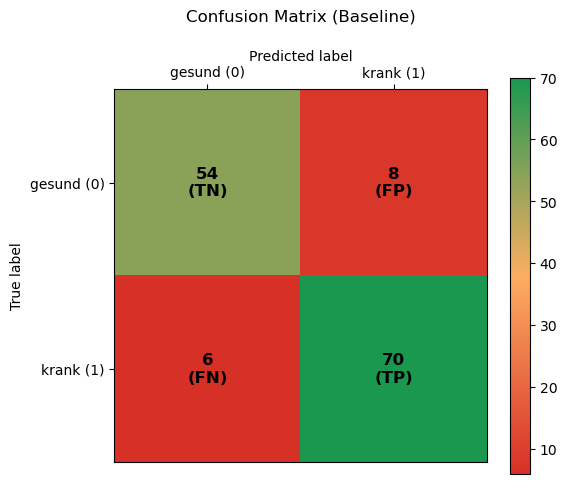

In [9]:
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

labels = ["gesund (0)", "krank (1)"]

cmap_traffic = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#d73027", "#fdae61", "#1a9850"]  # rot, orange, grün
)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=cmap_traffic)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):

        if i == 0 and j == 0:
            label = "(TN)"
        elif i == 0 and j == 1:
            label = "(FP)"
        elif i == 1 and j == 0:
            label = "(FN)"
        elif i == 1 and j == 1:
            label = "(TP)"

        ax.text(
            j, i,
            f"{cm[i, j]}\n{label}",
            ha="center", va="center",
            color="black",
            fontsize=12,
            fontweight="bold"
        )

ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)


ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Baseline)", pad=20)


plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

Die Confusion Matrix visualisiert die Entscheidungen des **Baseline-Random-Forest-Modells** auf dem Testdatensatz und zeigt, wie sich **korrekte** und **fehlerhafte Klassifikationen** auf beide Klassen verteilen.


Insgesamt zeigt die Confusion Matrix, dass das Baseline-Modell bereits

- eine **gute Erkennungsleistung für kranke Personen** aufweist,
- jedoch weiterhin **Verbesserungspotenzial** besitzt.

Insbesondere die verbleibenden **False Negatives** bilden den **zentralen Ausgangspunkt** für die nachfolgenden XAI-Analysen und gezielten Modellanpassungen.

## Identifikation und Charakterisierung kritischer Fehlklassifikationen

In diesem Abschnitt werden gezielt jene Testfälle identifiziert, bei denen das Modell für unseren Use-Case besonders relevante Fehler macht. Der Fokus liegt somit auf **False Negatives**, also tatsächlich kranken Personen, die vom Modell fälschlich als gesund eingestuft werden. Diese Fälle werden später den korrekt erkannten Kranken (**True Positives**) gegenübergestellt, um systematische Unterschiede sichtbar zu machen.

### Klassen-Vorhersagen und Wahrscheinlichkeiten

In [51]:
# Klassen-Vorhersagen 
y_pred = rf_model.predict(X_test_processed)

# Wahrscheinlichkeiten
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]

Die Klassen-Vorhersagen (`y_pred`) werden verwendet, um die Testdaten **eindeutig nach Entscheidungstypen des Modells** zu trennen, insbesondere um **False Negatives** und **True Positives** gezielt zu identifizieren.

Die Vorhersagewahrscheinlichkeiten (`y_proba`) werden ergänzt, um diese Fälle **quantitativ zu charakterisieren**. Sie zeigen, **wie stark das Modell von seiner Entscheidung überzeugt war** und ermöglichen es zu unterscheiden, ob False Negatives klare Fehlentscheidungen oder **Grenzfälle nahe der Entscheidungsschwelle** sind.

Gemeinsam erlauben `y_pred` und `y_proba` somit eine strukturierte Selektion und Anreicherung kritischer Fälle, die in den folgenden Schritten gezielt mit lokalen XAI-Methoden analysiert werden.

### False Negatives (Untersuchungsobjekt)

In [52]:
# False Negatives: krank (1) aber als gesund (0) vorhergesagt
fn_mask = (y_test == 1) & (y_pred == 0)

fn_cases = X_test_processed[fn_mask].copy()
fn_cases["y_true"] = y_test[fn_mask].values
fn_cases["y_pred"] = y_pred[fn_mask]
fn_cases["y_proba"] = y_proba[fn_mask]
display(fn_cases)

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
684  47.0      108.0        243.0        0.0  152.0      0.0    0.0    1.0   
889  59.0      134.0        204.0        0.0  162.0      0.8    0.0    1.0   
759  54.0      192.0        283.0        0.0  195.0      0.0    0.0    1.0   
763  58.0      132.0        224.0        0.0  173.0      3.2    0.0    1.0   
440  52.0      128.0          0.0        0.0  180.0      3.0    0.0    1.0   
1    49.0      160.0        180.0        0.0  156.0      1.0    1.0    0.0   

     ChestPainType_ASY  ChestPainType_ATA  ...  RestingECG_Normal  \
684                0.0                0.0  ...                1.0   
889                0.0                0.0  ...                1.0   
759                0.0                1.0  ...                0.0   
763                0.0                0.0  ...                0.0   
440                0.0                0.0  ...                0.0   
1                  0.0                0.0  ...                1.0   

     RestingECG_ST  ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  \
684            0.0               1.0               0.0            0.0   
889            0.0               1.0               0.0            0.0   
759            0.0               1.0               0.0            0.0   
763            0.0               1.0               0.0            0.0   
440            1.0               1.0               0.0            0.0   
1              0.0               1.0               0.0            0.0   

     ST_Slope_Flat  ST_Slope_Up  y_true  y_pred  y_proba  
684            0.0          1.0       1       0     0.00  
889            0.0          1.0       1       0     0.08  
759            0.0          1.0       1       0     0.21  
763            0.0          1.0       1       0     0.25  
440            0.0          1.0       1       0     0.41  
1              1.0          0.0       1       0     0.27  

[6 rows x 23 columns]

### True Positives (Referenz)

In [53]:
# True Positives: krank (1) und korrekt als krank vorhergesagt
tp_mask = (y_test == 1) & (y_pred == 1)

tp_cases = X_test_processed[tp_mask].copy()
tp_cases["y_true"] = y_test[tp_mask].values
tp_cases["y_pred"] = y_pred[tp_mask]
tp_cases["y_proba"] = y_proba[tp_mask]
display(tp_cases)

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
615  70.0      130.0        322.0        0.0  109.0      2.4    0.0    1.0   
383  38.0      110.0          0.0        0.0  156.0      0.0    1.0    0.0   
316  57.0      105.0          0.0        1.0  148.0      0.3    0.0    1.0   
351  43.0      140.0          0.0        0.0  140.0      0.5    0.0    1.0   
546  48.0      132.0        220.0        1.0  162.0      0.0    0.0    1.0   
..    ...        ...          ...        ...    ...      ...    ...    ...   
489  54.0      136.0        220.0        0.0  140.0      3.0    0.0    1.0   
313  34.0      115.0          0.0        1.0  154.0      0.2    0.0    1.0   
238  48.0      160.0        355.0        0.0   99.0      2.0    0.0    1.0   
242  55.0      160.0        292.0        1.0  143.0      2.0    0.0    1.0   
492  49.0      130.0          0.0        0.0  145.0      3.0    0.0    1.0   

     ChestPainType_ASY  ChestPainType_ATA  ...  RestingECG_Normal  \
615                1.0                0.0  ...                0.0   
383                1.0                0.0  ...                1.0   
316                0.0                0.0  ...                1.0   
351                1.0                0.0  ...                0.0   
546                0.0                0.0  ...                0.0   
..                 ...                ...  ...                ...   
489                1.0                0.0  ...                1.0   
313                1.0                0.0  ...                1.0   
238                1.0                0.0  ...                1.0   
242                0.0                1.0  ...                1.0   
492                0.0                0.0  ...                0.0   

     RestingECG_ST  ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  \
615            0.0               1.0               0.0            0.0   
383            0.0               1.0               0.0            0.0   
316            0.0               1.0               0.0            0.0   
351            1.0               0.0               1.0            0.0   
546            1.0               1.0               0.0            0.0   
..             ...               ...               ...            ...   
489            0.0               0.0               1.0            0.0   
313            0.0               1.0               0.0            0.0   
238            0.0               0.0               1.0            0.0   
242            0.0               0.0               1.0            0.0   
492            1.0               1.0               0.0            0.0   

     ST_Slope_Flat  ST_Slope_Up  y_true  y_pred  y_proba  
615            1.0          0.0       1       1     0.67  
383            1.0          0.0       1       1     0.67  
316            1.0          0.0       1       1     0.69  
351            0.0          1.0       1       1     0.76  
546            1.0          0.0       1       1     0.68  
..             ...          ...     ...     ...      ...  
489            1.0          0.0       1       1     1.00  
313            0.0          1.0       1       1     0.59  
238            1.0          0.0       1       1     0.98  
242            1.0          0.0       1       1     0.92  
492            1.0          0.0       1       1     0.70  

[70 rows x 23 columns]

## Vergleich der vorhergesagten Krankheitswahrscheinlichkeiten (FN vs. TP)

In [13]:
print("FN y_proba summary:")
print(fn_cases["y_proba"].describe())

print("\nTP y_proba summary:")
print(tp_cases["y_proba"].describe())

FN y_proba summary:
count    6.000000
mean     0.203333
std      0.145556
min      0.000000
25%      0.112500
50%      0.230000
75%      0.265000
max      0.410000
Name: y_proba, dtype: float64

TP y_proba summary:
count    70.000000
mean      0.833429
std       0.136529
min       0.530000
25%       0.720000
50%       0.845000
75%       0.967500
max       1.000000
Name: y_proba, dtype: float64


Die Zusammenfassung der vorhergesagten Wahrscheinlichkeiten zeigt einen klaren Unterschied zwischen **False Negatives** und **True Positives**.

False-Negative-Fälle weisen durchgehend **niedrige vorhergesagte Krankheitswahrscheinlichkeiten** auf. Selbst der höchste Wert liegt deutlich unter der Entscheidungsschwelle von 0.5, was darauf hindeutet, dass das Modell diese Fälle mit hoher Sicherheit als gesund eingestuft hat.

True-Positive-Fälle hingegen besitzen **durchgehend hohe Wahrscheinlichkeiten**, die klar oberhalb der Entscheidungsschwelle liegen. Dies zeigt, dass das Modell bei korrekt erkannten Krankheitsfällen meist sehr überzeugt ist.

Dieser deutliche Abstand zwischen beiden Gruppen legt nahe, dass False Negatives keine Grenzfälle an der Schwelle sind, sondern systematisch anders bewertet werden. Genau diese Fälle sind daher besonders relevant für die folgenden lokalen XAI-Analysen.

## Baseline-Metriken

In [14]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, fbeta_score

recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

print("Recall (HeartDisease = 1):", round(recall, 4))
print("Precision (HeartDisease = 1):", round(precision, 4))
print("F2-Score (HeartDisease = 1):", round(f2, 4))
print("Accuracy:", round(accuracy, 4))

Recall (HeartDisease = 1): 0.9211
Precision (HeartDisease = 1): 0.8974
F2-Score (HeartDisease = 1): 0.9162
Accuracy: 0.8986


---

# Phase 4: Globales XAI

---

# Phase 5: Lokales XAI

## Auswahl der Vergleichsgruppen

In [15]:
# 1) Echte Feature-Spalten definieren (aus processed Matrix)
feature_cols = X_train_processed.columns.tolist()

num_cols = numeric_features
cat_cols = [c for c in feature_cols if c not in num_cols]

# 2) Scaler NUR auf TRAIN fitten
scaler = StandardScaler()
scaler.fit(X_train_processed[num_cols])

# 3) Hilfsfunktion: Feature-Matrix für kNN bauen (ohne y_true/y_pred/y_proba)
def build_knn_matrix(df):
    X = df[feature_cols]  # nur echte Features
    X_num = scaler.transform(X[num_cols])
    X_cat = X[cat_cols].values
    return np.hstack([X_num, X_cat])

# 4) Matrizen bauen
X_fn = build_knn_matrix(fn_cases)
X_tp = build_knn_matrix(tp_cases)

fn_idx = fn_cases.index.to_list()
tp_idx = tp_cases.index.to_list()

# 5) kNN: für jeden FN die k ähnlichsten TP finden
k = 3
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_tp)

distances, indices = nn.kneighbors(X_fn)

# 6) Ergebnis-Tabelle
rows = []
for i, fn_id in enumerate(fn_idx):
    for r in range(k):
        tp_id = tp_idx[indices[i, r]]
        rows.append({
            "fn_id": fn_id,
            "tp_id": tp_id,
            "rank": r + 1,
            "distance": float(distances[i, r]),
            "fn_proba": float(fn_cases.loc[fn_id, "y_proba"]),
            "tp_proba": float(tp_cases.loc[tp_id, "y_proba"]),
        })

knn_matches_df = pd.DataFrame(rows).sort_values(["fn_id","rank"]).reset_index(drop=True)
knn_matches_df

fn_id  tp_id  rank  distance  fn_proba  tp_proba
0       1    264     1  2.310927      0.27      0.72
1       1    281     2  2.647454      0.27      0.97
2       1    735     3  2.779110      0.27      0.62
3     440    492     1  2.432686      0.41      0.70
4     440    735     2  3.261938      0.41      0.62
5     440    337     3  3.459791      0.41      0.69
6     684    104     1  2.391920      0.00      0.98
7     684    131     2  2.484117      0.00      0.88
8     684    735     3  2.539645      0.00      0.62
9     759    581     1  4.267965      0.21      0.74
10    759    585     2  4.388495      0.21      0.81
11    759    651     3  4.521571      0.21      0.89
12    763    786     1  2.429525      0.25      0.66
13    763    651     2  2.754583      0.25      0.89
14    763    735     3  2.890340      0.25      0.62
15    889    581     1  2.419694      0.08      0.74
16    889    735     2  2.772903      0.08      0.62
17    889    651     3  2.837886      0.08      0.89

Für **jeden False-Negative-Fall** wird eine kleine Gruppe von **strukturell ähnlichen True-Positive-Fällen** bestimmt. Konkret werden für jeden FN die **k = 3 nächstgelegenen TP-Fälle im Feature-Raum** gesucht, basierend auf allen vorverarbeiteten numerischen und kategorialen Merkmalen.

Auf diese Weise werden Fälle verglichen, die sich im Patientenprofil möglichst ähneln, sich jedoch **in der Modellentscheidung unterscheiden**.  
Dies ermöglicht es, Unterschiede zu identifizieren, die maßgeblich dazu beitragen, dass ein Patient trotz ähnlicher Merkmalsausprägungen einmal korrekt und einmal fälschlich klassifiziert wird.


### Verwendete Feature-Basis

Als Ausgangspunkt dienen die **tatsächlichen Feature-Spalten** aus der bereits vorverarbeiteten Matrix `X_*_processed`.

Dabei wird wie folgt vorgegangen:

- **Numerische Features**
  - werden standardisiert,
  - der Scaler wird **ausschließlich auf den Trainingsdaten gefittet**,
  - um **Data Leakage** zu vermeiden.
- **One-Hot-kodierte kategoriale Features**
  - bleiben **unverändert**.

Beide Feature-Typen werden anschließend zu einer **gemeinsamen Feature-Matrix** zusammengeführt.


### Ähnlichkeitsbestimmung mittels kNN

Auf der kombinierten Feature-Matrix wird ein **k-Nearest-Neighbors (kNN)-Modell** trainiert,

- **ausschließlich auf den True-Positive-Fällen**,
- um für jeden False Negative vergleichbare korrekt klassifizierte Fälle zu finden.

Für jeden FN werden die

- **k = 3 ähnlichsten True Positives**

ermittelt.


### Ergebnis: Matching-Tabelle für lokale XAI-Analysen

Das Ergebnis ist eine **Matching-Tabelle**, die für jeden False Negative enthält:

- die **FN-ID** (`fn_id`),
- die **IDs der ähnlichsten True Positives** (`tp_id`),
- den **Rang** der Ähnlichkeit,
- die **Distanz** als Ähnlichkeitsmaß,
- die vom Random Forest vorhergesagte Krankheitswahrscheinlichkeit
  - für den FN (`fn_proba`)
  - und für die jeweiligen TPs (`tp_proba`).

Diese strukturierte Zuordnung liefert **konkrete Vergleichspaare**, die anschließend für lokale XAI-Methoden (z. B. SHAP, LIME) genutzt werden können,  
um **gezielt Unterschiede zu identifizieren**, die die Modellentscheidung erklären.

## Vorbereitung lokaler SHAP-Erklärungen für das Random-Forest-Modell

In [16]:
shap.initjs()
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test_processed)
base_value = explainer.expected_value

# --- Robust auf "list" vs "3D array" reagieren ---
if isinstance(shap_values, list):
    # klassisch: [class0, class1]
    shap_values_1 = shap_values[1]              # (n_samples, n_features)
    base_value_1 = base_value[1] if isinstance(base_value, (list, np.ndarray)) else base_value
else:
    # neu/anders: (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        shap_values_1 = shap_values[:, :, 1]    # Klasse 1 -> (n_samples, n_features)
    else:
        shap_values_1 = shap_values             # fallback (sollte dann schon 2D sein)

    if isinstance(base_value, (list, np.ndarray)) and np.ndim(base_value) > 0:
        base_value_1 = base_value[1]
    else:
        base_value_1 = base_value

In dieser Zelle wird ein **SHAP-Explainer speziell für baum-basierte Modelle** initialisiert, um **lokale Erklärungen für einzelne Vorhersagen** des Random Forests zu berechnen. SHAP zerlegt dabei jede Modellentscheidung in **Feature-Beiträge**, die zeigen, wie einzelne Merkmale die Vorhersage in Richtung „krank“ oder „gesund“ verschieben.

Die berechneten SHAP-Werte liegen dabei **in der Log-Odds-Domäne** vor (Standardausgabe von `TreeExplainer` für Klassifikationsmodelle). Ein positiver SHAP-Wert erhöht die **Log-Odds für die Klasse „krank“**, ein negativer SHAP-Wert senkt sie entsprechend. Die Summe aus **Base Value** und allen Feature-Beiträgen ergibt die vom Modell berechnete Log-Odds-Vorhersage, die über die logistische Funktion in eine **Wahrscheinlichkeit** transformiert werden kann.

Da Random-Forest-Modelle bei Klassifikationsproblemen **SHAP-Werte in unterschiedlichen Formaten** zurückgeben können (abhängig von SHAP- und scikit-learn-Version), wird der Code bewusst **robust gestaltet**. Es wird geprüft, ob die SHAP-Werte

- als **Liste** (klassisch: eine Matrix pro Klasse) oder
- als **3D-Array**

vorliegen. In beiden Fällen werden gezielt die **SHAP-Werte für die positive Klasse (HeartDisease = 1)** extrahiert.

Zusätzlich wird der zugehörige **Base Value** für Klasse 1 bestimmt. Dieser Wert repräsentiert die **durchschnittliche Modellvorhersage in Log-Odds** und dient als **Referenzpunkt**, von dem aus die einzelnen Feature-Beiträge die finale Vorhersage nach oben oder unten verschieben.

## Lokaler SHAP-Vergleich: False Negative vs. ähnliche True Positives

In [17]:
def get_shap_row(idx):
    row_pos = X_test_processed.index.get_loc(idx)
    x_row = X_test_processed.loc[idx]
    s_row = shap_values_1[row_pos].ravel()  # ravel() stellt sicher, dass es 1D ist
    return row_pos, x_row, s_row


def plot_waterfall(idx, title):
    row_pos, x_row, s_row = get_shap_row(idx)

    exp = shap.Explanation(
        values=s_row,
        base_values=base_value_1,
        data=x_row.values,
        feature_names=X_test_processed.columns
    )

    plt.figure()
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def compare_fn_to_tps(fn_id, k=3):
    # passende TPs holen
    matches = (
        knn_matches_df[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)
    )

    tp_ids = matches["tp_id"].tolist()

    print(
        "FN:", fn_id,
        "proba:", float(fn_cases.loc[fn_id, "y_proba"])
    )
    display(matches)

    # 1) Waterfall für FN
    plot_waterfall(
        fn_id,
        f"FN {fn_id} (p={fn_cases.loc[fn_id, 'y_proba']:.3f})"
    )

    # 2) Waterfall für die k ähnlichsten TPs
    for tp_id in tp_ids:
        plot_waterfall(
            tp_id,
            f"TP {tp_id} (p={tp_cases.loc[tp_id, 'y_proba']:.3f})"
        )

In dieser Zelle werden **Hilfsfunktionen** definiert, um **lokale SHAP-Erklärungen auf Einzelfallebene** zu erzeugen und systematisch miteinander zu vergleichen.

Zunächst wird für einen gegebenen Testfall

- die zugehörige **Feature-Ausprägung**
- sowie die entsprechenden **SHAP-Werte**

extrahiert. Darauf aufbauend werden **SHAP-Waterfall-Plots** erzeugt, die visualisieren, wie einzelne Merkmale die Modellvorhersage **relativ zum Base Value** nach oben oder unten verschieben.


Für jeden ausgewählten **False-Negative-Fall** werden anschließend die zuvor bestimmten **k ähnlichsten True-Positive-Fälle** herangezogen.

Die lokalen SHAP-Erklärungen dieser Fälle werden **direkt gegenübergestellt**, sodass sichtbar wird,

- **welche Feature-Beiträge sich unterscheiden** und
- **an welchen Stellen die Modellentscheidung kippt** (von „krank“ zu „gesund“).

Diese Gegenüberstellung bildet die Grundlage für die detaillierte Analyse lokaler Fehlmechanismen.

## Feature-basierter SHAP-Vergleich für eine FN–TP-Gruppe

In [35]:
def _get_row_pos(idx):
    return X_test_processed.index.get_loc(idx)

def _get_shap_vector(idx):
    row_pos = _get_row_pos(idx)
    s = shap_values_1[row_pos].ravel()
    return s


# Vergleichstabelle: ALLE Features nach FN_SHAP + Werte (val)
def make_waterfall_compare_table(fn_id, k=3, sort_by="abs_delta", ascending=False):
    # 1) tp_ids holen (ohne matches-DataFrame zu bauen)
    tp_ids = (
        knn_matches_df.loc[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)["tp_id"]
        .tolist()
    )

    # 2) SHAP-Vektoren ziehen (alle Features)
    row_fn = X_test_processed.index.get_loc(fn_id)
    fn_shap = shap_values_1[row_fn].ravel()  # (n_features,)

    tp_shaps = []
    for tp_id in tp_ids:
        row_tp = X_test_processed.index.get_loc(tp_id)
        tp_shaps.append(shap_values_1[row_tp].ravel())

    tp_shaps = np.vstack(tp_shaps)              # (k, n_features)
    mean_tp_shap = tp_shaps.mean(axis=0)        # (n_features)

    # 3) Feature-Werte (alle Features)
    feature_names = X_test_processed.columns.tolist()

    fn_vals = X_test_processed.loc[fn_id, feature_names].values
    tp_vals_list = [X_test_processed.loc[tp_id, feature_names].values for tp_id in tp_ids]

    # 4) Delta
    delta = fn_shap - mean_tp_shap
    abs_delta = np.abs(delta)

    # 5) DataFrame bauen (alle Features)
    data = {
        "feature": feature_names,
        "FN_val": fn_vals,
        "FN_SHAP": fn_shap,
    }

    for j, tp_id in enumerate(tp_ids, start=1):
        data[f"TP{j}_{tp_id}_val"] = tp_vals_list[j - 1]
        data[f"TP{j}_{tp_id}_SHAP"] = tp_shaps[j - 1]

    df = pd.DataFrame(data)
    df["meanTP_SHAP"] = mean_tp_shap
    df["Delta_FN_minus_meanTP"] = delta
    df["abs_delta"] = abs_delta
    df["delta_sign"] = np.sign(delta).astype(int)
    df["fn_id"] = fn_id

    # 6) Werte formatieren:
    #    - Binäre Features (OHE etc) als int 0/1
    #    - andere numerische Features bleiben float
    val_cols = [c for c in df.columns if c.endswith("_val")]
    for c in val_cols:
        col = pd.to_numeric(df[c], errors="coerce")
        uniq = set(col.dropna().unique().tolist())
        if uniq.issubset({0, 1}):
            df[c] = col.round(0).astype("Int64")  # 0/1 als int
        else:
            df[c] = col.astype(float)             # numerisch lassen

    # SHAP-Spalten runden
    shap_cols = [c for c in df.columns if c.endswith("_SHAP")] + [
        "meanTP_SHAP", "Delta_FN_minus_meanTP", "abs_delta"
    ]
    shap_cols = list(dict.fromkeys(shap_cols))  # duplicates raus
    df.loc[:, shap_cols] = df[shap_cols].astype(float).round(3)

    # 7) Standard: sortiere wie Waterfall nach |FN_SHAP|
    df = df.sort_values(by="FN_SHAP", key=np.abs, ascending=False).reset_index(drop=True)

    return df

# Decision Plot für genau diese Gruppe (FN + k TPs)

def plot_decision_for_fn_group(fn_id, k=3, title_prefix="Decision Plot"):
    matches = (
        knn_matches_df[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)
    )

    tp_ids = matches["tp_id"].tolist()

    idxs = [fn_id] + tp_ids
    row_positions = [_get_row_pos(i) for i in idxs]

    shap_subset = shap_values_1[row_positions, :]
    X_subset = X_test_processed.loc[idxs]

    plt.figure()
    shap.decision_plot(
        base_value_1,
        shap_subset,
        X_subset,
        feature_names=X_test_processed.columns.tolist(),
        show=False
    )
    plt.title(f"{title_prefix}: FN {fn_id} vs {k} similar TPs")
    plt.tight_layout()
    plt.show()

    return matches

Um nicht nur **visuell** (Waterfall), sondern auch **systematisch und tabellarisch** zu vergleichen, wird hier eine Vergleichslogik aufgebaut, die für einen bestimmten **False Negative** die **k ähnlichsten True Positives** heranzieht und deren **Feature-Beiträge (SHAP-Werte)** gegenüberstellt.

Ziel ist es, auf Feature-Ebene sichtbar zu machen,

- **welche Merkmale beim FN anders wirken** als bei sehr ähnlichen, korrekt klassifizierten TPs
- und welche Features somit zur Fehlentscheidung beitragen.


Mit `make_waterfall_compare_table(...)` wird für einen FN:

- die passende **kNN-Match-Gruppe**  
  (FN + *k* ähnlichste TPs) geladen,
- für **alle Features**
  - die Feature-Werte
  - und die zugehörigen SHAP-Werte
  gesammelt,
- für die TPs zusätzlich der **mittlere SHAP-Wert** berechnet  
  (`meanTP_SHAP`).

Als zentrale Vergleichsgröße wird anschließend die **mittlere absolute Abweichung**
der SHAP-Werte berechnet:

$$
\overline{|\Delta|}
=
\left|
\mathrm{FN}_{\mathrm{SHAP}}
-
\overline{\mathrm{TP}_{\mathrm{SHAP}}}
\right|
$$

Diese Kennzahl misst,

- wie stark sich der Einfluss eines Features beim **False Negative**
- insgesamt von dem Einfluss bei **vergleichbaren True Positives** unterscheidet  
- **unabhängig von der Richtung** des Effekts.

Damit rückt nicht die Frage

> „zieht das Feature nach oben oder unten?“

in den Fokus, sondern vielmehr:

> **„Wie ungewöhnlich stark ist der Beitrag dieses Features im FN  
> im Vergleich zu ähnlichen korrekt klassifizierten Fällen?“**

Features mit einem hohen $\overline{|\Delta|}$-Wert sind somit besonders geeignet, um **systematische Ursachen für Fehlklassifikationen** zu identifizieren.


Damit die Tabelle gut interpretierbar bleibt, wird sie zusätzlich formatiert:

- **One-Hot-Encoded Features** werden explizit als **0 / 1** dargestellt,
- **SHAP-Werte** werden gerundet,
- die **Sortierung** erfolgt standardmäßig analog zum Waterfall-Plot nach $\left| \text{FN\_SHAP} \right|$, sodass die **wichtigsten Treiber zuerst erscheinen**.

Mit `plot_decision_for_fn_group(...)` kann anschließend die gesamte Gruppe (**FN + k TPs**) als **Decision Plot** visualisiert werden, um die **kumulative Wirkung der wichtigsten Features** über mehrere ähnliche Fälle hinweg direkt miteinander zu vergleichen.

## Lokale XAI-Analyse eines False-Negative-Falls (ID 684)

FN: 684 proba: 0.0


fn_id  tp_id  rank  distance  fn_proba  tp_proba
6    684    104     1  2.391920       0.0      0.98
7    684    131     2  2.484117       0.0      0.88
8    684    735     3  2.539645       0.0      0.62

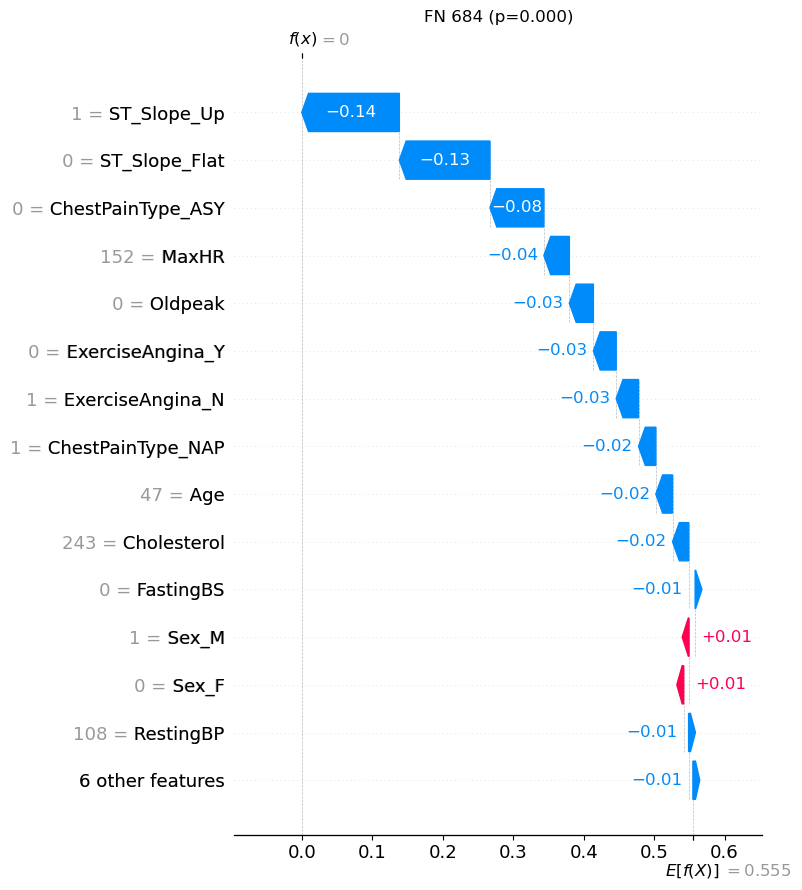

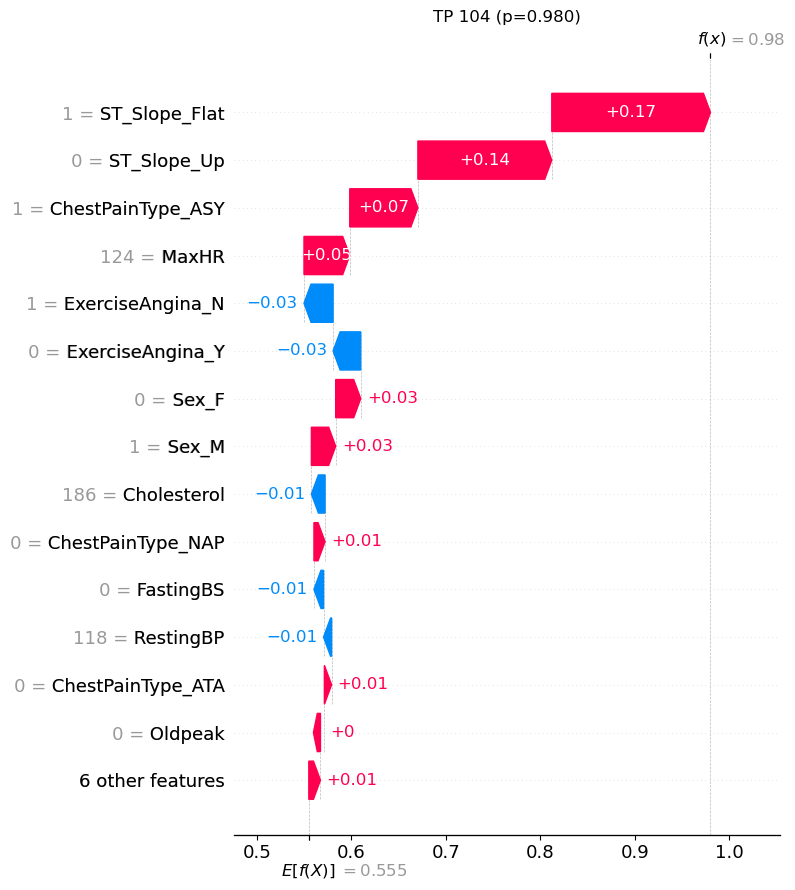

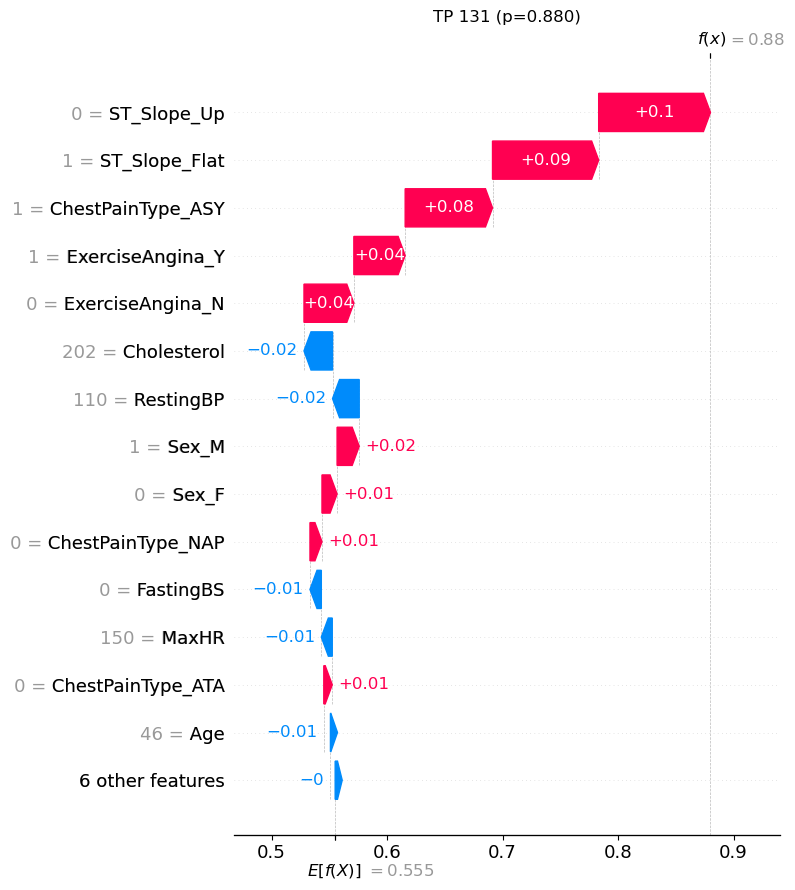

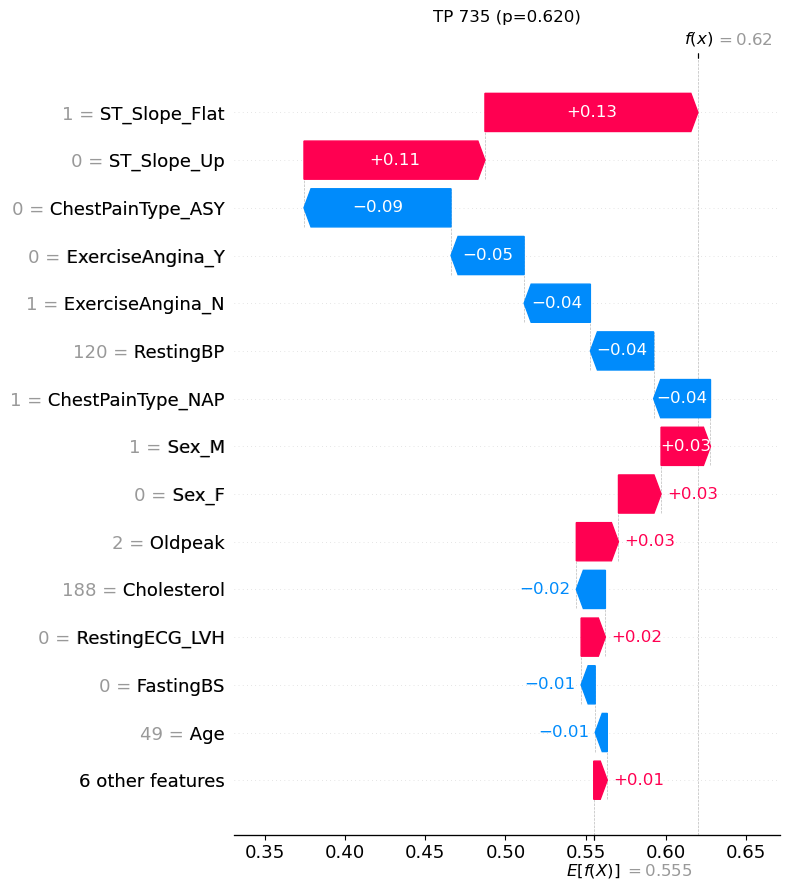

feature  FN_val  FN_SHAP  TP1_104_val  TP1_104_SHAP  \
0         ST_Slope_Up     1.0   -0.138          0.0         0.142   
1       ST_Slope_Flat     0.0   -0.129          1.0         0.168   
2   ChestPainType_ASY     0.0   -0.076          1.0         0.072   
3               MaxHR   152.0   -0.036        124.0         0.048   
4             Oldpeak     0.0   -0.034          0.0         0.004   
5    ExerciseAngina_N     1.0   -0.032          1.0        -0.031   
6    ExerciseAngina_Y     0.0   -0.032          0.0        -0.029   
7   ChestPainType_NAP     1.0   -0.025          0.0         0.012   
8                 Age    47.0   -0.024         46.0         0.003   
9         Cholesterol   243.0   -0.023        186.0        -0.014   
10              Sex_M     1.0    0.009          1.0         0.026   
11          FastingBS     0.0   -0.009          0.0        -0.010   
12              Sex_F     0.0    0.008          0.0         0.026   
13          RestingBP   108.0   -0.007        118.0        -0.009   
14  RestingECG_Normal     1.0   -0.004          1.0         0.003   
15  ChestPainType_ATA     0.0    0.004          0.0         0.008   
16      ST_Slope_Down     0.0   -0.004          0.0         0.000   
17      RestingECG_ST     0.0   -0.001          0.0         0.001   
18   ChestPainType_TA     0.0   -0.000          0.0         0.001   
19     RestingECG_LVH     0.0   -0.000          0.0         0.003   

    TP2_131_val  TP2_131_SHAP  TP3_735_val  TP3_735_SHAP  meanTP_SHAP  \
0           0.0         0.097          0.0         0.113        0.117   
1           1.0         0.092          1.0         0.133        0.131   
2           1.0         0.076          0.0        -0.092        0.019   
3         150.0        -0.009        139.0         0.004        0.014   
4           0.0        -0.005          2.0         0.026        0.009   
5           0.0         0.043          1.0        -0.041       -0.010   
6           1.0         0.044          0.0        -0.046       -0.010   
7           0.0         0.010          1.0        -0.035       -0.004   
8          46.0        -0.006         49.0        -0.008       -0.003   
9         202.0        -0.025        188.0        -0.018       -0.019   
10          1.0         0.019          1.0         0.031        0.025   
11          0.0        -0.010          0.0        -0.009       -0.010   
12          0.0         0.013          0.0         0.027        0.022   
13        110.0        -0.023        120.0        -0.039       -0.024   
14          1.0         0.001          1.0         0.005        0.003   
15          0.0         0.007          0.0         0.002        0.006   
16          0.0        -0.002          0.0        -0.000       -0.001   
17          0.0         0.003          0.0        -0.001        0.001   
18          0.0         0.001          0.0        -0.001        0.000   
19          0.0        -0.001          0.0         0.015        0.006   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                  -0.256      0.256          -1    684  
1                  -0.259      0.259          -1    684  
2                  -0.095      0.095          -1    684  
3                  -0.050      0.050          -1    684  
4                  -0.043      0.043          -1    684  
5                  -0.022      0.022          -1    684  
6                  -0.022      0.022          -1    684  
7                  -0.020      0.020          -1    684  
8                  -0.020      0.020          -1    684  
9                  -0.004      0.004          -1    684  
10                 -0.017      0.017          -1    684  
11                  0.001      0.001           1    684  
12                 -0.014      0.014          -1    684  
13                  0.017      0.017           1    684  
14                 -0.007      0.007          -1    684  
15                 -0.001      0.001          -1    684  
16                 -0.003      0.003        

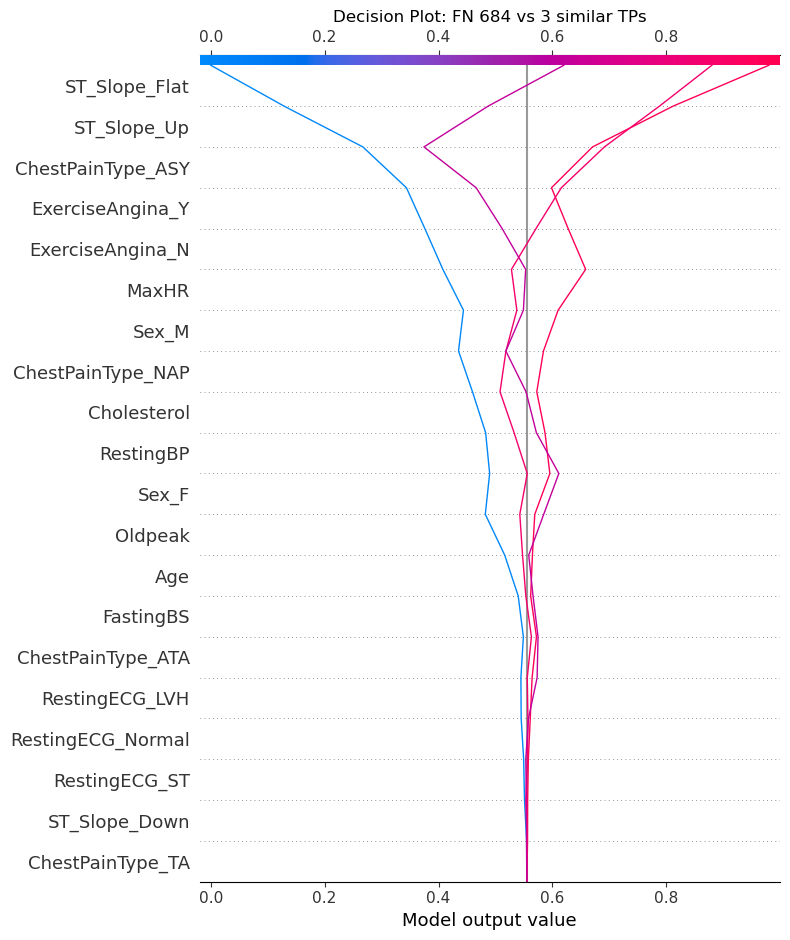

In [34]:
fn_id = 684

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table= make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[0]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)  

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)

Im Folgenden analysieren wir exemplarisch den False-Negative-Fall **ID 684**, um zu verstehen, warum das Modell eine tatsächlich kranke Person mit sehr hoher Sicherheit als gesund einstuft (`p(krank) = 0.00`). Ziel dieser Analyse ist es, **an einem konkreten Beispiel** zu zeigen, wie lokale XAI-Erklärungen (Waterfall-Tabelle und Decision Plot) zu interpretieren sind.

Die Analyse erfolgt **nicht isoliert**, sondern im Vergleich zu **drei sehr ähnlichen True-Positive-Fällen**, die vom Modell korrekt als krank erkannt wurden. Dadurch lässt sich untersuchen, **bei welchen Merkmalen sich der False Negative systematisch von typischen True Positives unterscheidet**, obwohl die Patienten im Feature-Space ähnlich sind.

Der Fokus liegt dabei explizit auf der Kennzahl **`mean_abs_delta`**, also der **mittleren absoluten Abweichung der SHAP-Werte zwischen dem False Negative und den ähnlichsten True Positives**. Diese Kennzahl misst **die Stärke der Abweichung eines Features über vergleichbare Fälle hinweg**, unabhängig von der Richtung des Effekts, und bildet damit die **zentrale Größe der lokalen Analyse**.

Die Erkenntnisse aus diesem Einzelfall werden anschließend **über alle False Negatives hinweg aggregiert**, anstatt jeden Fehlfall einzeln ausführlich zu diskutieren.


### Das Feature *ST_Slope* – medizinischer Hintergrund

In der folgenden Untersuchung wird insbesondere das Feature **ST_Slope** betrachtet, da es im Vergleich zwischen False Negative und ähnlichen True Positives eine der **höchsten mittleren absoluten Abweichungen (`mean_abs_delta`)** aufweist. Das Feature beschreibt das Verhalten der ST-Strecke im Belastungs-EKG. Vereinfacht gilt:

- **ST_Slope_Up (ansteigend)** → meist unauffällig  
- **ST_Slope_Flat (flach)** → auffällig  
- **ST_Slope_Down (abfallend)** → stark auffällig, hohes Risiko  

Medizinisch betrachtet ist **ST_Slope_Down** das deutlichste Warnsignal, während **ST_Slope_Up** eher als harmlos gilt und **ST_Slope_Flat** eine Zwischenstufe darstellt.


### Repräsentation von *ST_Slope* im Modell (One-Hot-Encoding)

Das kategoriale Merkmal *ST_Slope* wird mittels **One-Hot-Encoding (OHE)** in drei binäre Spalten überführt:

- `ST_Slope_Up`
- `ST_Slope_Flat`
- `ST_Slope_Down`

Dabei ist pro Patient **genau eine dieser Spalten auf 1 gesetzt**, die übrigen haben den Wert 0.

Für Patient **684** gilt:
- `ST_Slope_Up = 1`
- `ST_Slope_Flat = 0`
- `ST_Slope_Down = 0`

Das Modell verarbeitet somit **kein medizinisches Label**, sondern ein **konkretes Muster aus binären Eingaben**, das es während des Trainings mit Zielwerten verknüpft hat.


### Interpretation der Waterfall-Tabelle 

Die Waterfall-Tabelle stellt für **alle Features** gegenüber:
- die SHAP-Werte des False-Negative-Falls,
- die SHAP-Werte der drei ähnlichsten True Positives,
- sowie die **mittlere absolute Abweichung (`mean_abs_delta`) zwischen False Negative und True Positives**.

Im Zentrum der Analyse steht **nicht ein einzelner Vergleich**, sondern die **durchschnittliche Stärke der Abweichung über mehrere ähnliche Fälle hinweg**. Ein hohes `mean_abs_delta` zeigt an, dass ein Feature **beim False Negative systematisch anders wirkt als bei vergleichbaren True Positives**, unabhängig davon, ob der Effekt positiv oder negativ ist.


### Zentrale Beobachtung

Die höchsten Werte von **`mean_abs_delta`** treten bei den Features:

- **ST_Slope_Up**
- **ST_Slope_Flat**

auf.

Diese Merkmale weisen im Mittel eine **deutlich größere absolute Abweichung** zwischen False Negative und True Positives auf als alle übrigen Features.  
Sie sind damit genau jene Merkmale, **bei denen sich der False Negative am stärksten vom typischen Entscheidungsverhalten des Modells unterscheidet**.

Erst in einem zweiten Schritt wird die **Richtung dieser Abweichung** betrachtet. Während die SHAP-Werte für `ST_Slope_Up` und `ST_Slope_Flat` bei den ähnlichen True Positives im Mittel **positiv** sind, weisen sie beim False Negative **stark negative Werte** auf. Entscheidend für ihre Identifikation ist jedoch **nicht das Vorzeichen**, sondern die **konsistent hohe mittlere Abweichung**, ausgedrückt durch `mean_abs_delta`.


### Warum *mean_abs_delta* entscheidend ist

Der zentrale Erkenntnisgewinn liegt darin, dass wenige Features eine **stabile und über mehrere Vergleichsfälle hinweg konsistente Abweichung** vom typischen Krankheitsmuster zeigen.

Die hohen `mean_abs_delta`-Werte verdeutlichen, dass die Kombination aus:
- `ST_Slope_Up = 1`
- `ST_Slope_Flat = 0`

beim False Negative **eine untypische Modellreaktion auslöst**, die sich im Durchschnitt klar von der Reaktion bei ähnlichen True Positives unterscheidet. Andere Merkmale wie Cholesterin, MaxHR oder Oldpeak weisen zwar ebenfalls SHAP-Effekte auf, ihre **mittleren absoluten Abweichungen sind jedoch deutlich geringer**.

Die Fehlklassifikation entsteht somit nicht durch ein einzelnes fehlendes Risikosignal, sondern durch eine **systematische Abweichung in wenigen, stark wirksamen Features**, die das Entscheidungsverhalten des Modells dominieren.


### Interpretation des Decision Plots

Der Decision Plot bestätigt diese **mean_abs_delta-basierte Interpretation** auf Prozessebene.  
Die Vorhersage des False-Negative-Falls (blaue Linie) unterscheidet sich bereits sehr früh im Entscheidungsprozess deutlich vom mittleren Verlauf der True Positives.

Die größten Abweichungen treten erneut bei:

- `ST_Slope_Up`
- `ST_Slope_Flat`

auf, genau jenen Features mit den höchsten `mean_abs_delta`-Werten. Nach dieser frühen Phase ist die Modellentscheidung weitgehend festgelegt; spätere Features tragen nur noch geringfügig zur verbleibenden Abweichung bei.


### Rolle von *ST_Slope_Down*

Obwohl **ST_Slope_Down** medizinisch hoch relevant ist, zeigt dieses Feature in dieser Analyse nur eine sehr geringe mittlere Abweichung (`mean_abs_delta ≈ 0`). Der Grund ist, dass `ST_Slope_Down = 0` sowohl beim False Negative als auch bei den betrachteten True Positives vorliegt.

Ein niedriger `mean_abs_delta`-Wert bedeutet hier **keine medizinische Irrelevanz**, sondern lediglich, dass dieses Feature **keinen Beitrag zur Unterscheidung zwischen FN und TP in diesem Vergleich leistet**.


### Zusammenfassung des Einzelfalls

Der False-Negative-Fall **ID 684** ist kein Grenzfall nahe der Entscheidungsschwelle, sondern das Ergebnis einer **klaren und konsistenten Abweichung vom typischen True-Positive-Muster**:

- Die größten Unterschiede liegen bei den Features mit dem höchsten **`mean_abs_delta`**
- Diese Abweichungen sind über mehrere ähnliche Vergleichsfälle stabil
- Wenige Merkmale dominieren die Modellentscheidung
- Dadurch wird das Krankheitsrisiko systematisch unterschätzt

Dieser Einzelfall zeigt exemplarisch, wie lokale Modellentscheidungen durch **konsistente Abweichungen einzelner Features** geprägt sein können und bildet die Grundlage für die **aggregierte Analyse aller False Negatives**.

---

## 2) FN_ID:1

FN: 1 proba: 0.27


fn_id  tp_id  rank  distance  fn_proba  tp_proba
0      1    264     1  2.310927      0.27      0.72
1      1    281     2  2.647454      0.27      0.97
2      1    735     3  2.779110      0.27      0.62

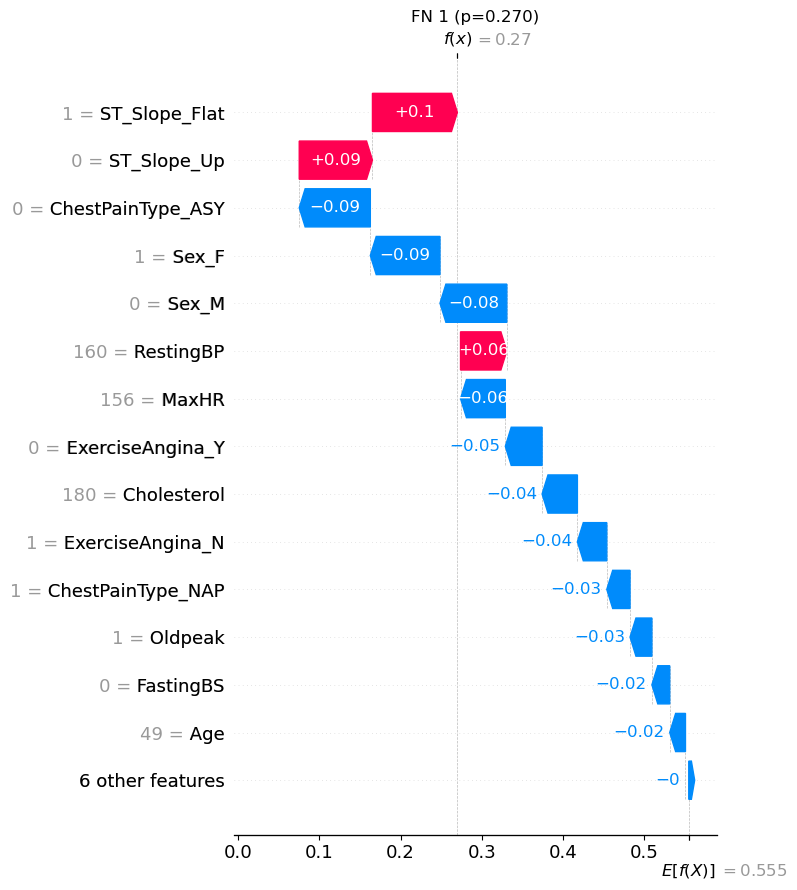

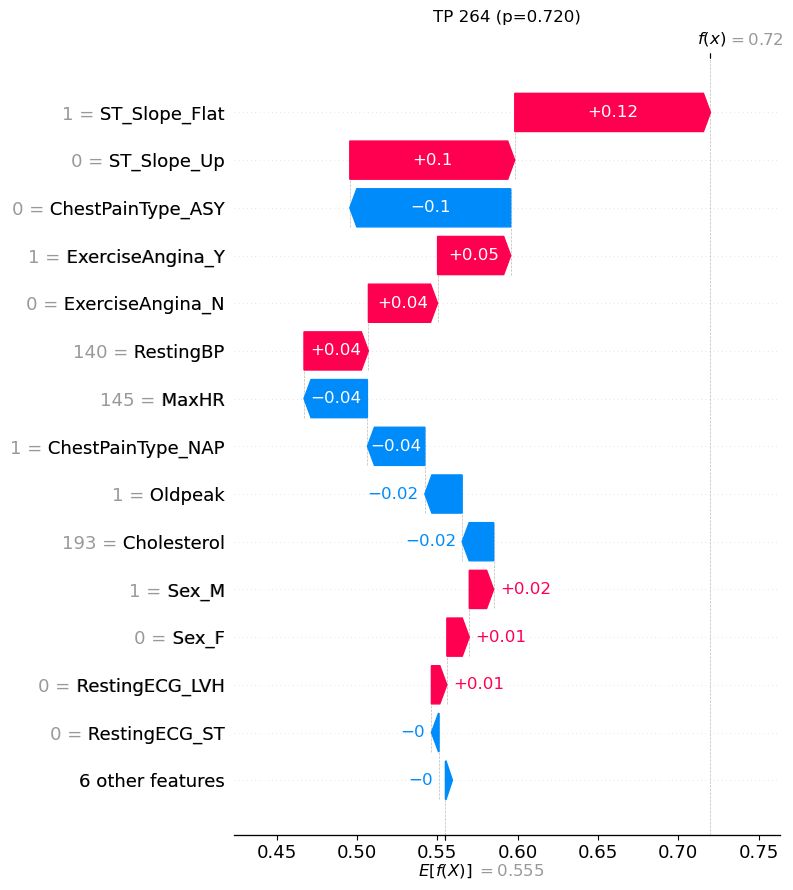

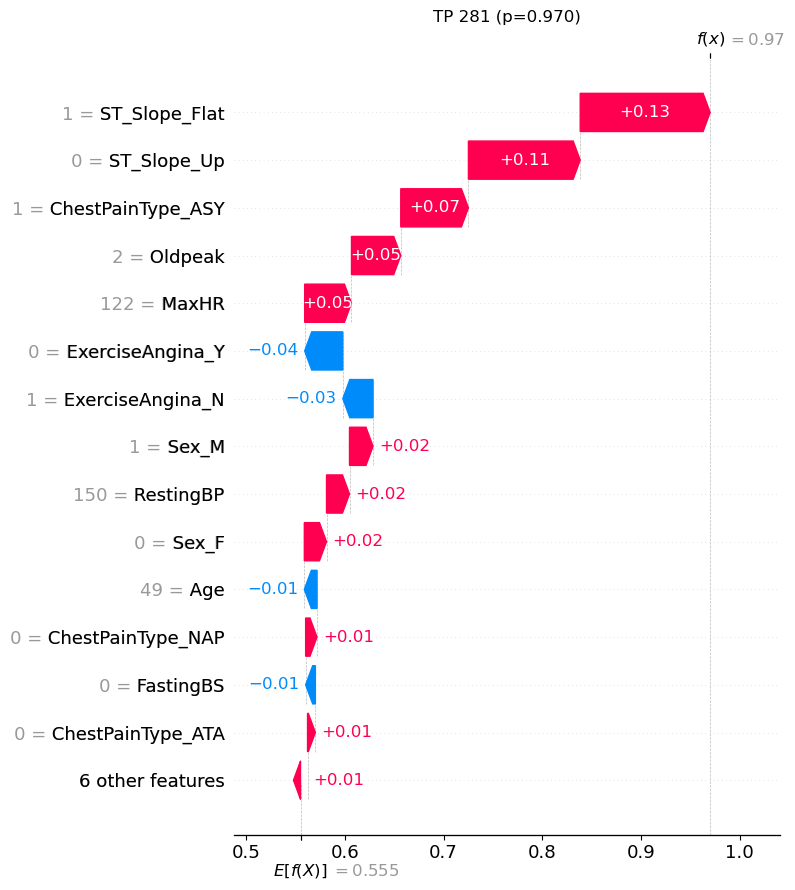

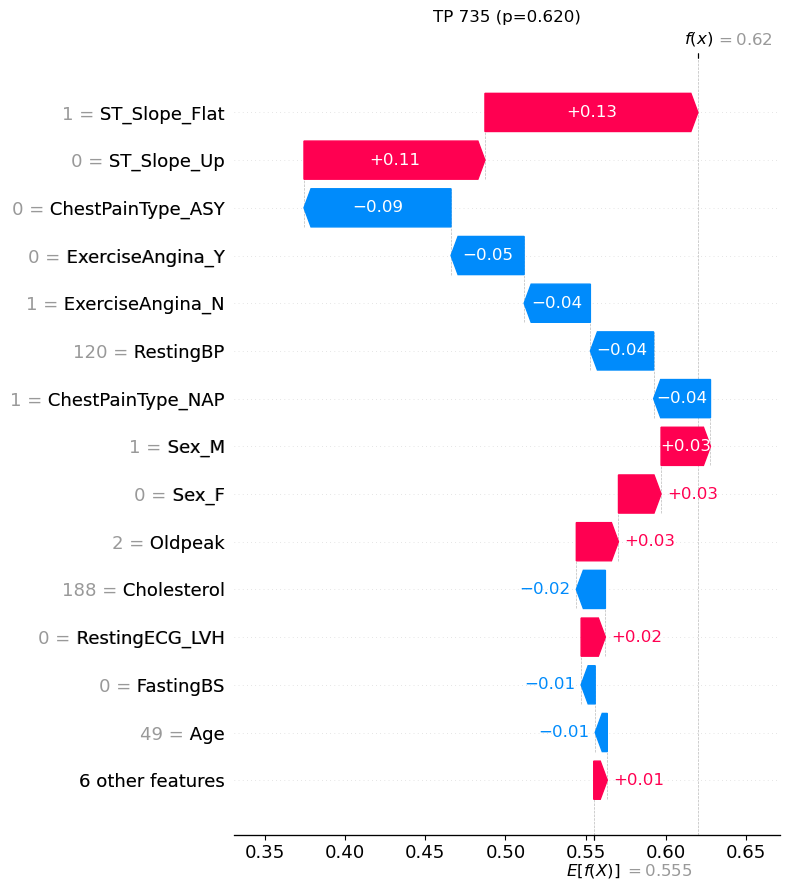

feature  FN_val  FN_SHAP  TP1_264_val  TP1_264_SHAP  \
0       ST_Slope_Flat     1.0    0.105          1.0         0.122   
1         ST_Slope_Up     0.0    0.090          0.0         0.103   
2   ChestPainType_ASY     0.0   -0.088          0.0        -0.100   
3               Sex_F     1.0   -0.086          0.0         0.014   
4               Sex_M     0.0   -0.082          1.0         0.015   
5           RestingBP   160.0    0.057        140.0         0.040   
6               MaxHR   156.0   -0.055        145.0        -0.039   
7    ExerciseAngina_Y     0.0   -0.045          1.0         0.046   
8         Cholesterol   180.0   -0.043        193.0        -0.020   
9    ExerciseAngina_N     1.0   -0.036          0.0         0.043   
10  ChestPainType_NAP     1.0   -0.029          1.0        -0.036   
11            Oldpeak     1.0   -0.027          1.0        -0.023   
12          FastingBS     0.0   -0.022          0.0        -0.004   
13                Age    49.0   -0.019         47.0        -0.001   
14     RestingECG_LVH     0.0    0.005          0.0         0.010   
15   ChestPainType_TA     0.0   -0.003          0.0        -0.000   
16      RestingECG_ST     0.0   -0.003          0.0        -0.005   
17  ChestPainType_ATA     0.0   -0.002          0.0         0.004   
18      ST_Slope_Down     0.0   -0.002          0.0        -0.002   
19  RestingECG_Normal     1.0    0.001          1.0        -0.001   

    TP2_281_val  TP2_281_SHAP  TP3_735_val  TP3_735_SHAP  meanTP_SHAP  \
0           1.0         0.132          1.0         0.133        0.129   
1           0.0         0.113          0.0         0.113        0.110   
2           1.0         0.069          0.0        -0.092       -0.041   
3           0.0         0.022          0.0         0.027        0.021   
4           1.0         0.024          1.0         0.031        0.023   
5         150.0         0.023        120.0        -0.039        0.008   
6         122.0         0.047        139.0         0.004        0.004   
7           0.0        -0.039          0.0        -0.046       -0.013   
8         222.0        -0.003        188.0        -0.018       -0.013   
9           1.0        -0.031          1.0        -0.041       -0.010   
10          0.0         0.012          1.0        -0.035       -0.020   
11          2.0         0.050          2.0         0.026        0.018   
12          0.0        -0.010          0.0        -0.009       -0.008   
13         49.0        -0.013         49.0        -0.008       -0.007   
14          0.0         0.000          0.0         0.015        0.008   
15          0.0         0.003          0.0        -0.001        0.001   
16          0.0         0.002          0.0        -0.001       -0.001   
17          0.0         0.008          0.0         0.002        0.004   
18          0.0         0.002          0.0        -0.000       -0.000   
19          1.0         0.003          1.0         0.005        0.002   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                  -0.024      0.024          -1      1  
1                  -0.019      0.019          -1      1  
2                  -0.046      0.046          -1      1  
3                  -0.107      0.107          -1      1  
4                  -0.106      0.106          -1      1  
5                   0.049      0.049           1      1  
6                  -0.059      0.059          -1      1  
7                  -0.032      0.032          -1      1  
8                  -0.030      0.030          -1      1  
9                  -0.027      0.027          -1      1  
10                 -0.009      0.009          -1      1  
11                 -0.045      0.045          -1      1  
12                 -0.014      0.014          -1      1  
13                 -0.012      0.012          -1      1  
14                 -0.004      0.004          -1      1  
15                 -0.004      0.004          -1      1  
16                 -0.002      0.002        

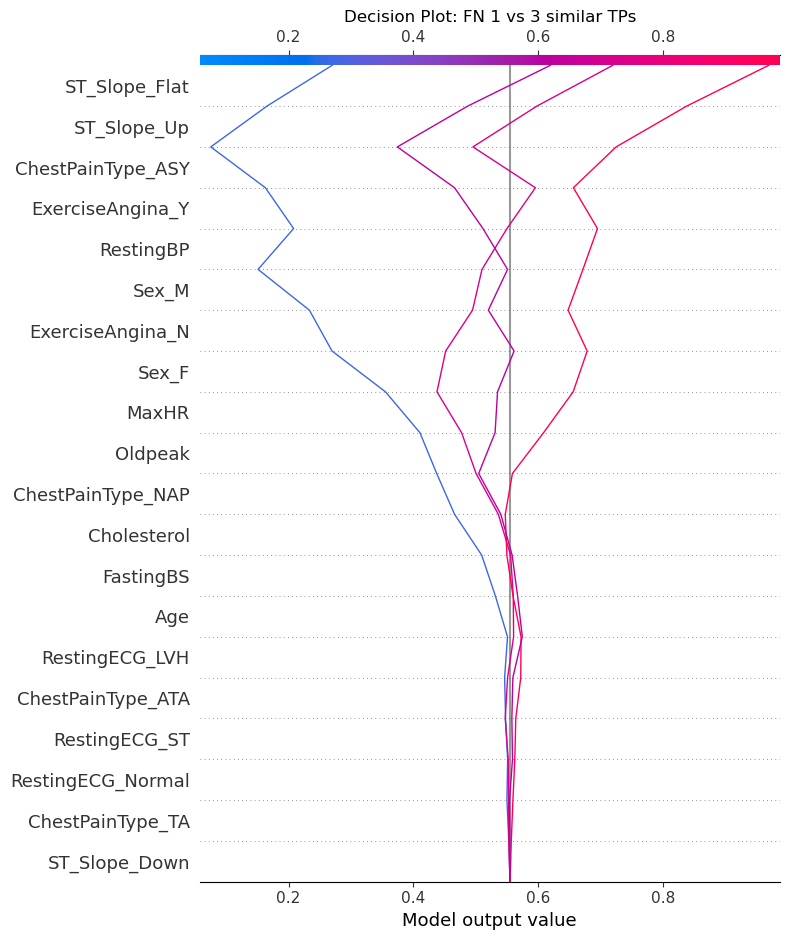

In [38]:
fn_id = 1

waterfall_table = make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[4]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   

matches = plot_decision_for_fn_group(fn_id, k=3)

## 3) FN_ID: 440

FN: 440 proba: 0.41


fn_id  tp_id  rank  distance  fn_proba  tp_proba
3    440    492     1  2.432686      0.41      0.70
4    440    735     2  3.261938      0.41      0.62
5    440    337     3  3.459791      0.41      0.69

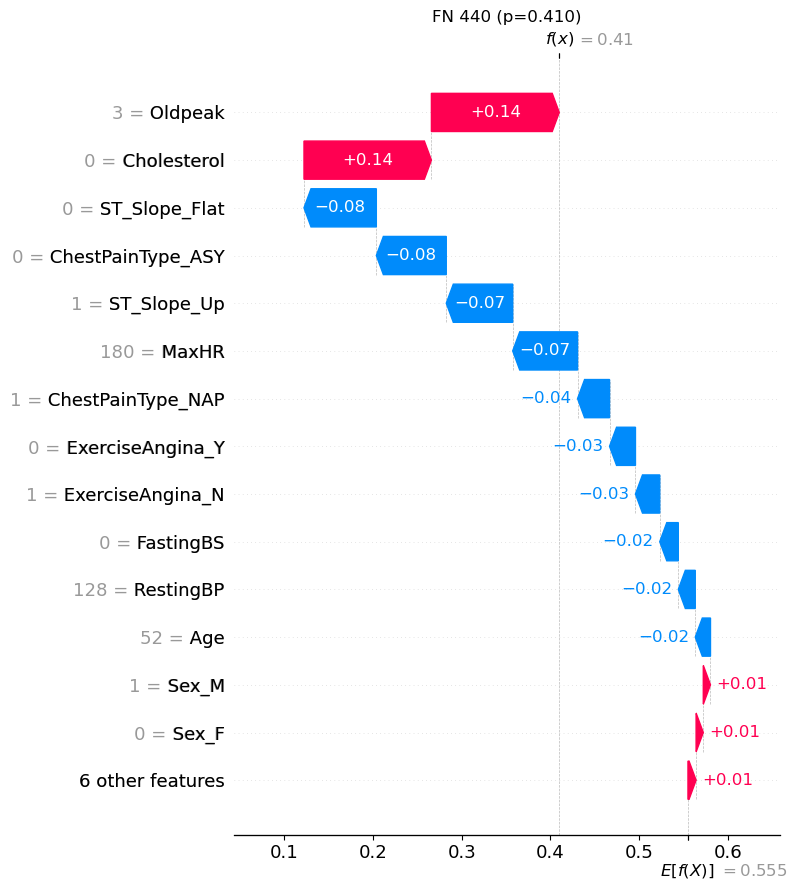

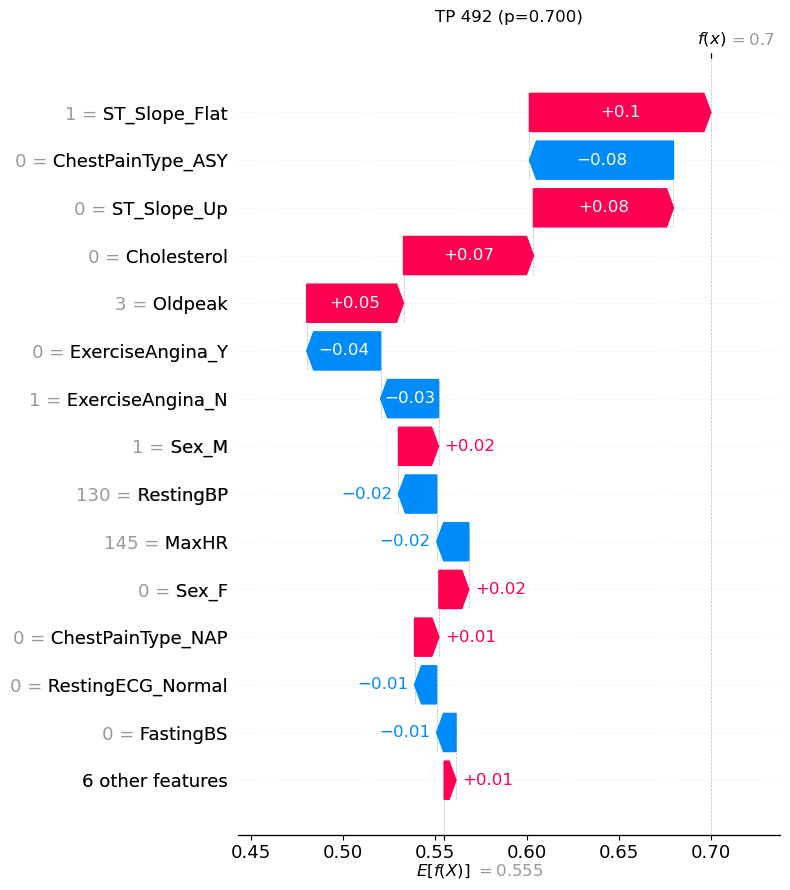

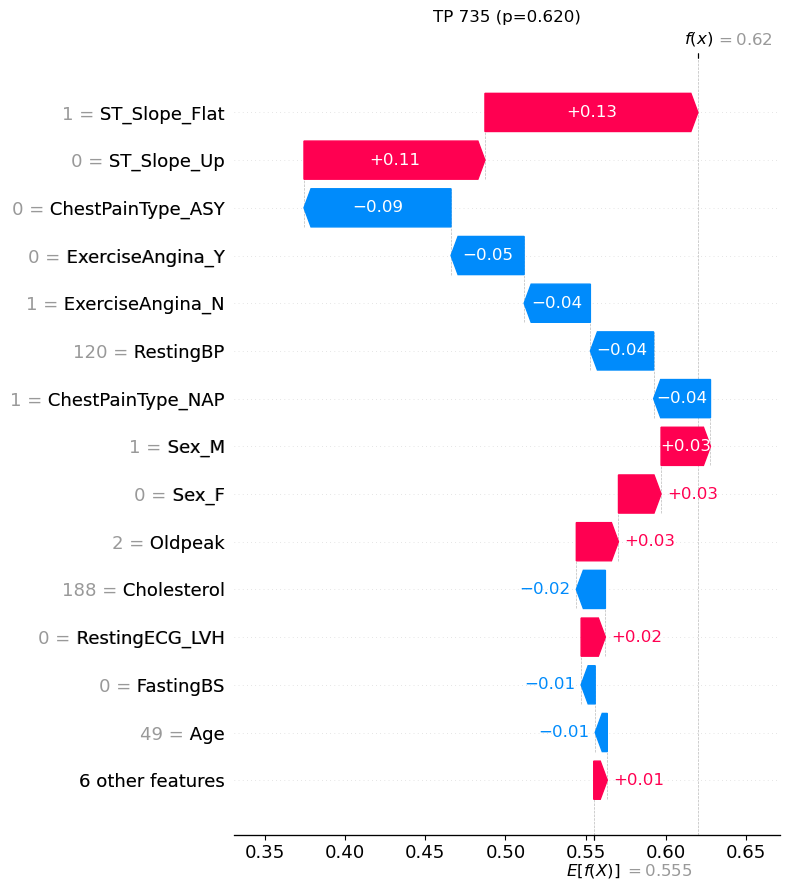

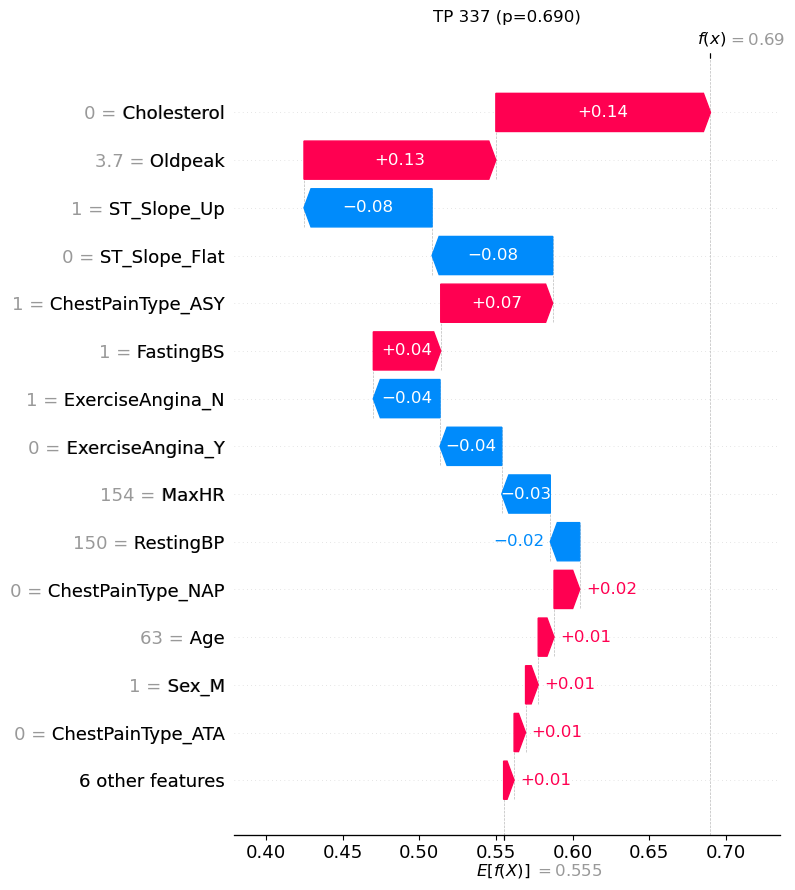

feature  FN_val  FN_SHAP  TP1_492_val  TP1_492_SHAP  \
0         Cholesterol     0.0    0.144          0.0         0.071   
1             Oldpeak     3.0    0.144          3.0         0.053   
2       ST_Slope_Flat     0.0   -0.082          1.0         0.099   
3   ChestPainType_ASY     0.0   -0.079          0.0        -0.078   
4         ST_Slope_Up     1.0   -0.075          0.0         0.076   
5               MaxHR   180.0   -0.073        145.0        -0.017   
6   ChestPainType_NAP     1.0   -0.036          0.0         0.013   
7    ExerciseAngina_Y     0.0   -0.029          0.0        -0.040   
8    ExerciseAngina_N     1.0   -0.027          1.0        -0.031   
9           FastingBS     0.0   -0.021          0.0        -0.011   
10          RestingBP   128.0   -0.019        130.0        -0.021   
11                Age    52.0   -0.017         49.0        -0.003   
12              Sex_F     0.0    0.008          0.0         0.016   
13              Sex_M     1.0    0.008          1.0         0.022   
14  ChestPainType_ATA     0.0    0.007          0.0         0.003   
15      RestingECG_ST     1.0    0.004          1.0        -0.001   
16     RestingECG_LVH     0.0   -0.003          0.0         0.009   
17      ST_Slope_Down     0.0    0.001          0.0         0.002   
18   ChestPainType_TA     0.0   -0.000          1.0        -0.004   
19  RestingECG_Normal     0.0   -0.000          0.0        -0.012   

    TP2_735_val  TP2_735_SHAP  TP3_337_val  TP3_337_SHAP  meanTP_SHAP  \
0         188.0        -0.018          0.0         0.140        0.064   
1           2.0         0.026          3.7         0.125        0.068   
2           1.0         0.133          0.0        -0.079        0.051   
3           0.0        -0.092          1.0         0.073       -0.032   
4           0.0         0.113          1.0        -0.084        0.035   
5         139.0         0.004        154.0        -0.032       -0.015   
6           1.0        -0.035          0.0         0.017       -0.002   
7           0.0        -0.046          0.0        -0.040       -0.042   
8           1.0        -0.041          1.0        -0.044       -0.039   
9           0.0        -0.009          1.0         0.044        0.008   
10        120.0        -0.039        150.0        -0.019       -0.026   
11         49.0        -0.008         63.0         0.010       -0.000   
12          0.0         0.027          0.0         0.004        0.016   
13          1.0         0.031          1.0         0.008        0.020   
14          0.0         0.002          0.0         0.007        0.004   
15          0.0        -0.001          1.0         0.005        0.001   
16          0.0         0.015          0.0        -0.003        0.007   
17          0.0        -0.000          0.0         0.002        0.001   
18          0.0        -0.001          0.0         0.001       -0.001   
19          1.0         0.005          0.0        -0.002       -0.003   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                   0.079      0.079           1    440  
1                   0.076      0.076           1    440  
2                  -0.132      0.132          -1    440  
3                  -0.047      0.047          -1    440  
4                  -0.110      0.110          -1    440  
5                  -0.058      0.058          -1    440  
6                  -0.034      0.034          -1    440  
7                   0.013      0.013           1    440  
8                   0.011      0.011           1    440  
9                  -0.029      0.029          -1    440  
10                  0.007      0.007           1    440  
11                 -0.017      0.017          -1    440  
12                 -0.007      0.007          -1    440  
13                 -0.012      0.012          -1    440  
14                  0.003      0.003           1    440  
15                  0.003      0.003           1    440  
16                 -0.010      0.010        

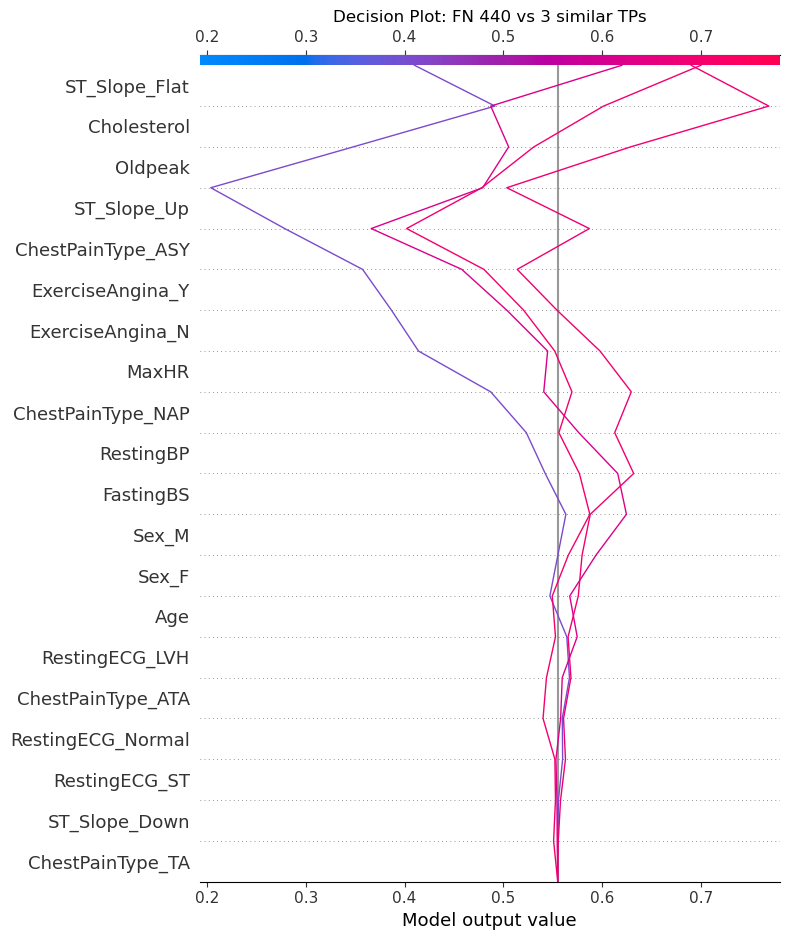

In [48]:
fn_id = 440

waterfall_table = make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[5]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   

matches = plot_decision_for_fn_group(fn_id, k=3)

## 4) FN_ID: 759

FN: 759 proba: 0.21


fn_id  tp_id  rank  distance  fn_proba  tp_proba
9     759    581     1  4.267965      0.21      0.74
10    759    585     2  4.388495      0.21      0.81
11    759    651     3  4.521571      0.21      0.89

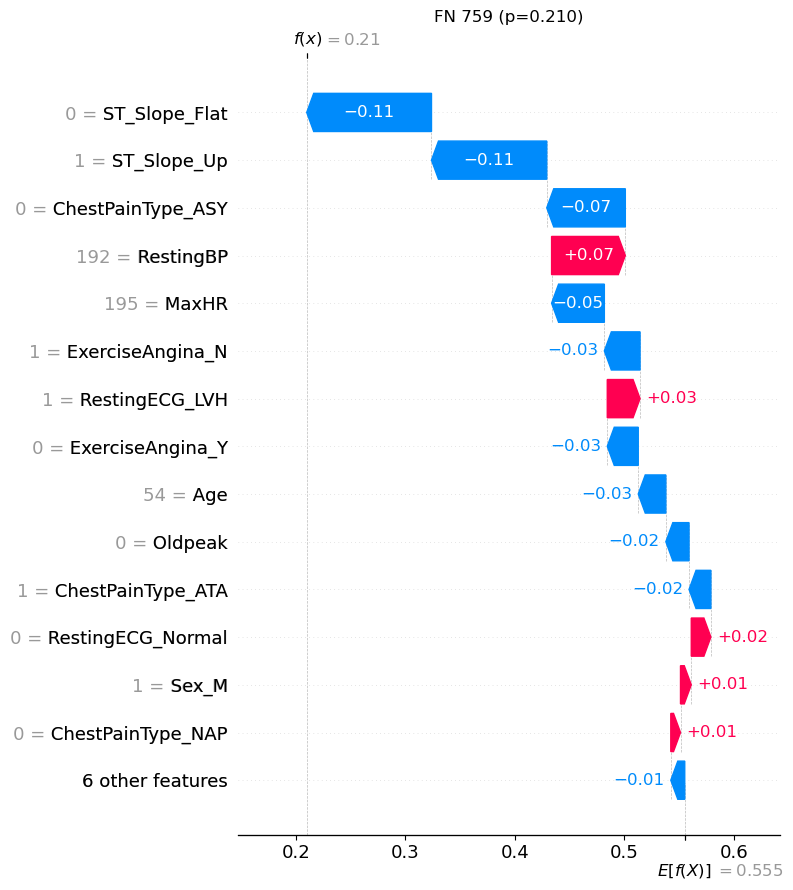

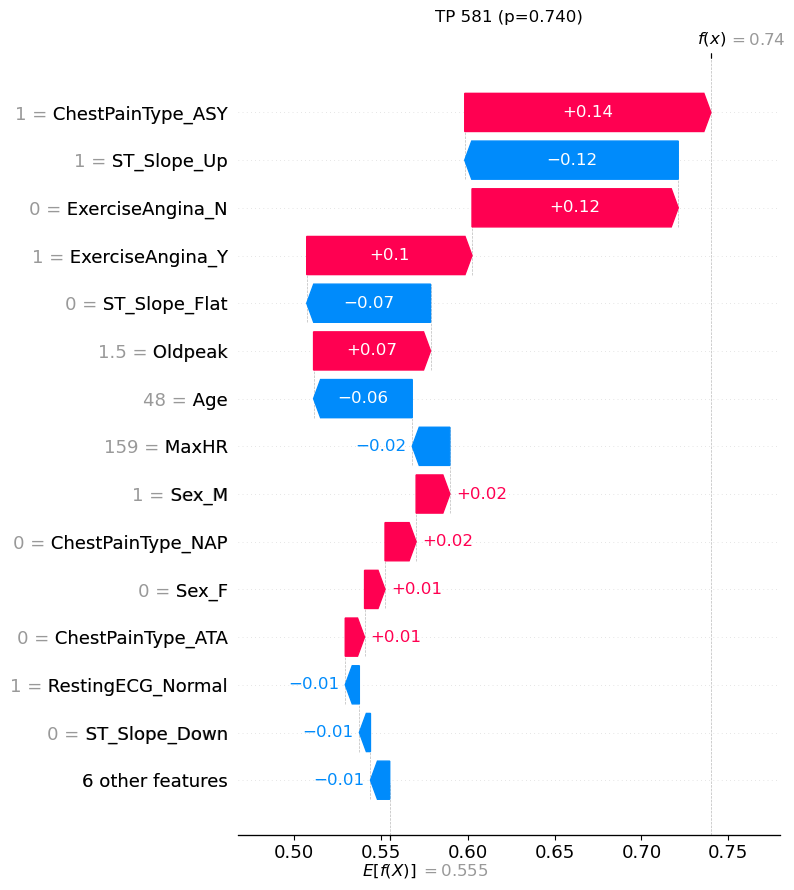

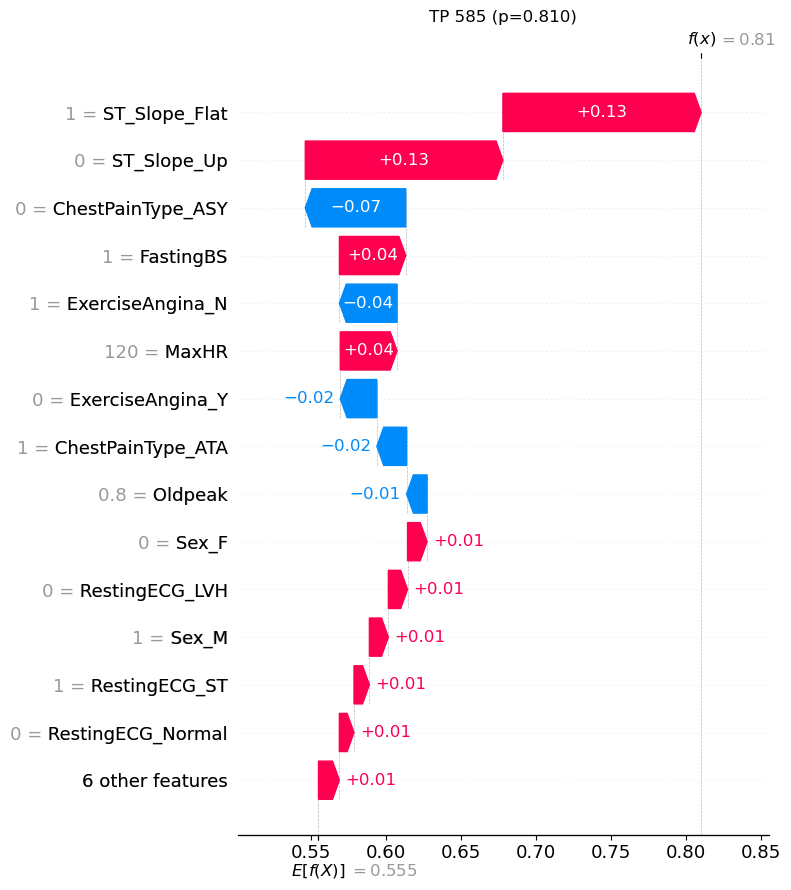

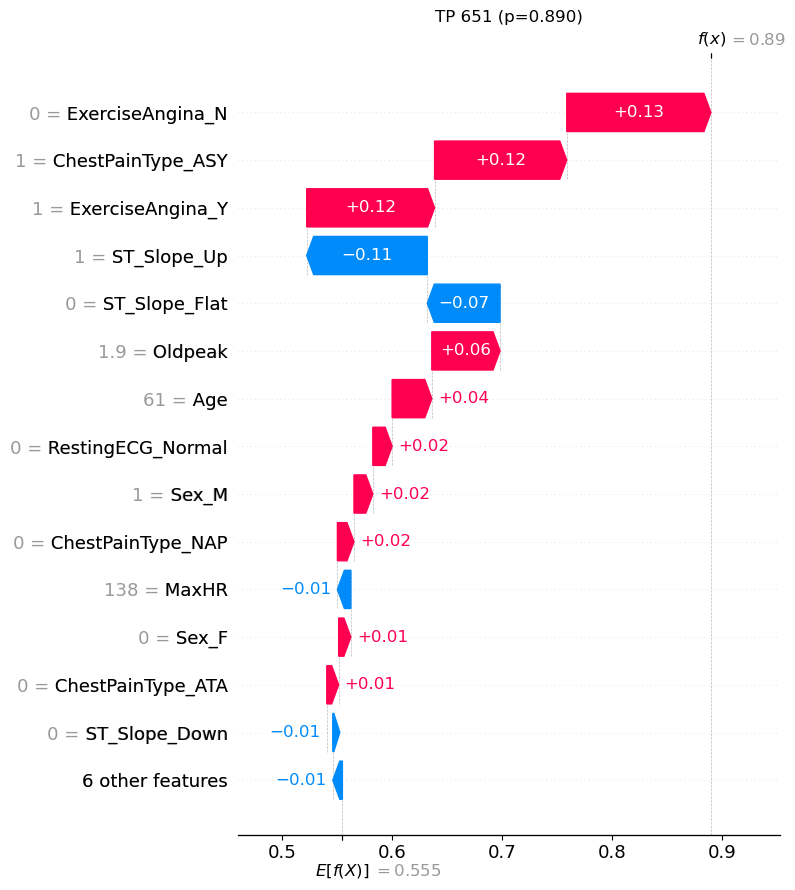

feature  FN_val  FN_SHAP  TP1_581_val  TP1_581_SHAP  \
0       ST_Slope_Flat     0.0   -0.114          0.0        -0.071   
1         ST_Slope_Up     1.0   -0.105          1.0        -0.123   
2   ChestPainType_ASY     0.0   -0.072          1.0         0.142   
3           RestingBP   192.0    0.067        140.0        -0.006   
4               MaxHR   195.0   -0.048        159.0        -0.022   
5    ExerciseAngina_N     1.0   -0.033          0.0         0.119   
6      RestingECG_LVH     1.0    0.030          0.0        -0.002   
7    ExerciseAngina_Y     0.0   -0.028          1.0         0.095   
8                 Age    54.0   -0.025         48.0        -0.057   
9             Oldpeak     0.0   -0.021          1.5         0.067   
10  ChestPainType_ATA     1.0   -0.020          0.0         0.011   
11  RestingECG_Normal     0.0    0.018          1.0        -0.008   
12              Sex_M     1.0    0.010          1.0         0.019   
13  ChestPainType_NAP     0.0    0.009          0.0         0.018   
14              Sex_F     0.0    0.006          0.0         0.012   
15          FastingBS     0.0   -0.006          0.0        -0.002   
16        Cholesterol   283.0   -0.005        208.0        -0.001   
17   ChestPainType_TA     0.0   -0.004          0.0         0.002   
18      ST_Slope_Down     0.0   -0.003          0.0        -0.006   
19      RestingECG_ST     0.0   -0.001          0.0        -0.003   

    TP2_585_val  TP2_585_SHAP  TP3_651_val  TP3_651_SHAP  meanTP_SHAP  \
0           1.0         0.132          0.0        -0.066       -0.002   
1           0.0         0.132          1.0        -0.110       -0.034   
2           0.0        -0.067          1.0         0.120        0.065   
3         180.0         0.002        140.0        -0.003       -0.002   
4         120.0         0.038        138.0        -0.012        0.001   
5           1.0        -0.038          0.0         0.131        0.070   
6           0.0         0.013          1.0         0.003        0.005   
7           0.0        -0.024          1.0         0.116        0.062   
8          57.0         0.003         61.0         0.036       -0.006   
9           0.8        -0.014          1.9         0.062        0.039   
10          1.0        -0.020          0.0         0.011        0.001   
11          0.0         0.010          0.0         0.018        0.006   
12          1.0         0.013          1.0         0.017        0.016   
13          0.0         0.006          0.0         0.015        0.013   
14          0.0         0.013          0.0         0.011        0.012   
15          1.0         0.044          0.0        -0.005        0.013   
16        285.0         0.001        207.0        -0.002       -0.001   
17          0.0         0.003          0.0         0.002        0.002   
18          0.0         0.000          0.0        -0.005       -0.004   
19          1.0         0.010          0.0        -0.004        0.001   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                  -0.112      0.112          -1    759  
1                  -0.072      0.072          -1    759  
2                  -0.137      0.137          -1    759  
3                   0.070      0.070           1    759  
4                  -0.049      0.049          -1    759  
5                  -0.103      0.103          -1    759  
6                   0.025      0.025           1    759  
7                  -0.091      0.091          -1    759  
8                  -0.019      0.019          -1    759  
9                  -0.060      0.060          -1    759  
10                 -0.021      0.021          -1    759  
11                  0.012      0.012           1    759  
12                 -0.007      0.007          -1    759  
13                 -0.004      0.004          -1    759  
14                 -0.006      0.006          -1    759  
15                 -0.018      0.018          -1    759  
16                 -0.004      0.004        

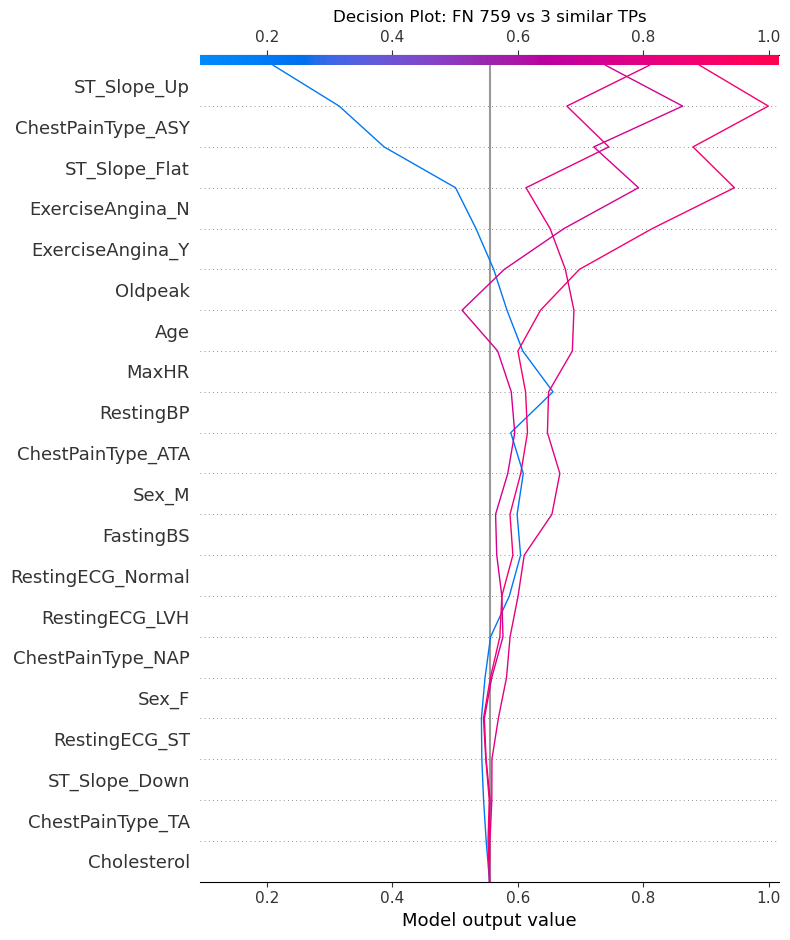

In [47]:
fn_id = 759

waterfall_table = make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[2]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   

matches = plot_decision_for_fn_group(fn_id, k=3)

## 5) FN_ID: 763

FN: 763 proba: 0.25


fn_id  tp_id  rank  distance  fn_proba  tp_proba
12    763    786     1  2.429525      0.25      0.66
13    763    651     2  2.754583      0.25      0.89
14    763    735     3  2.890340      0.25      0.62

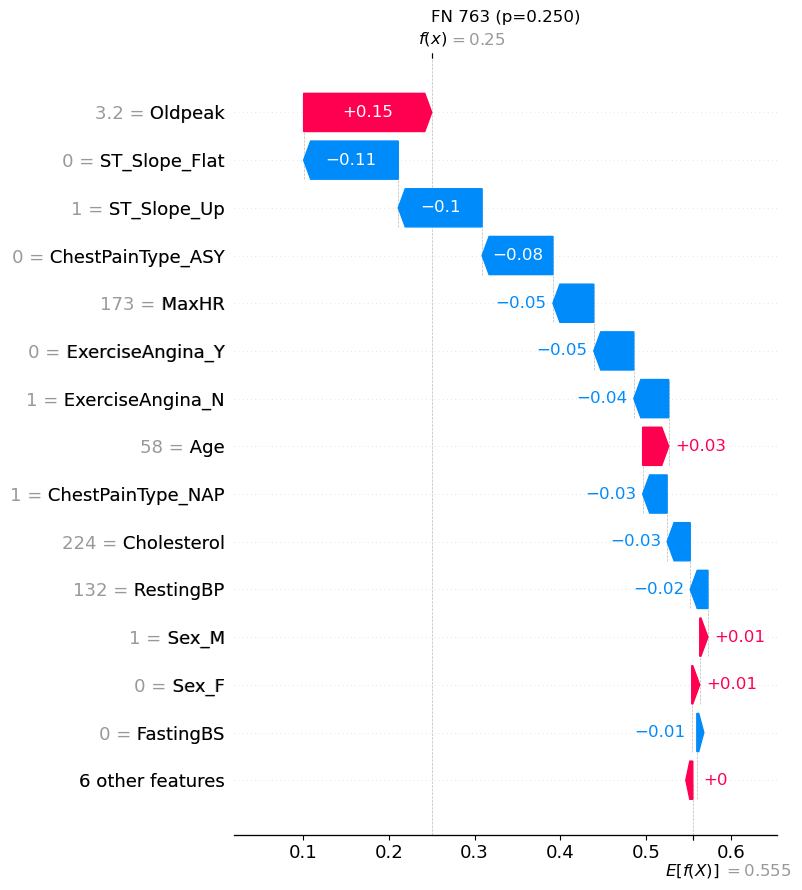

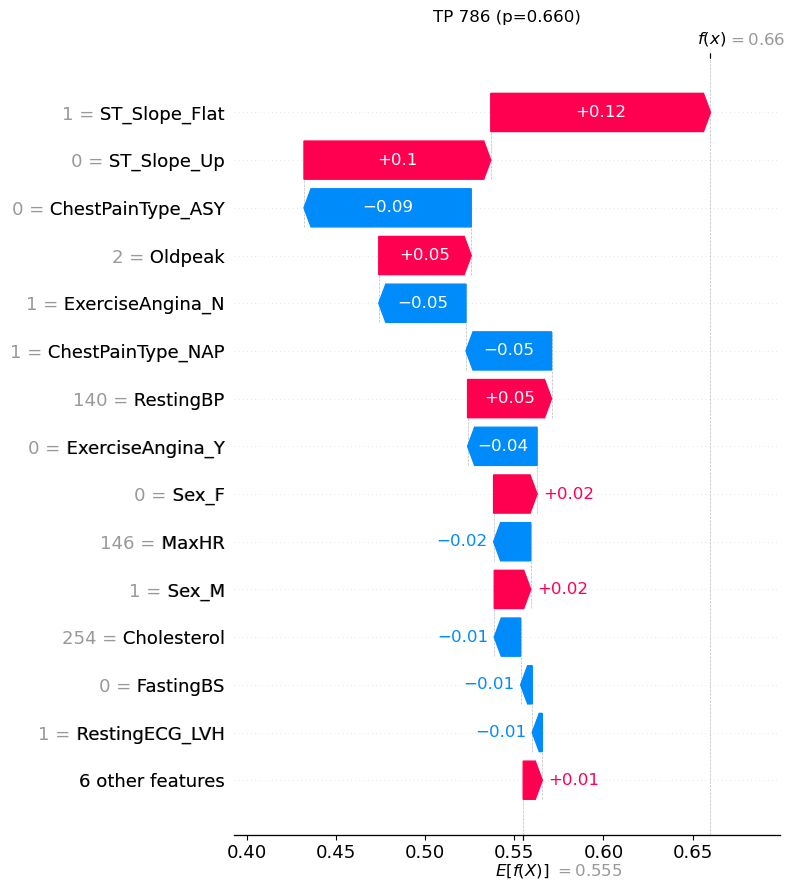

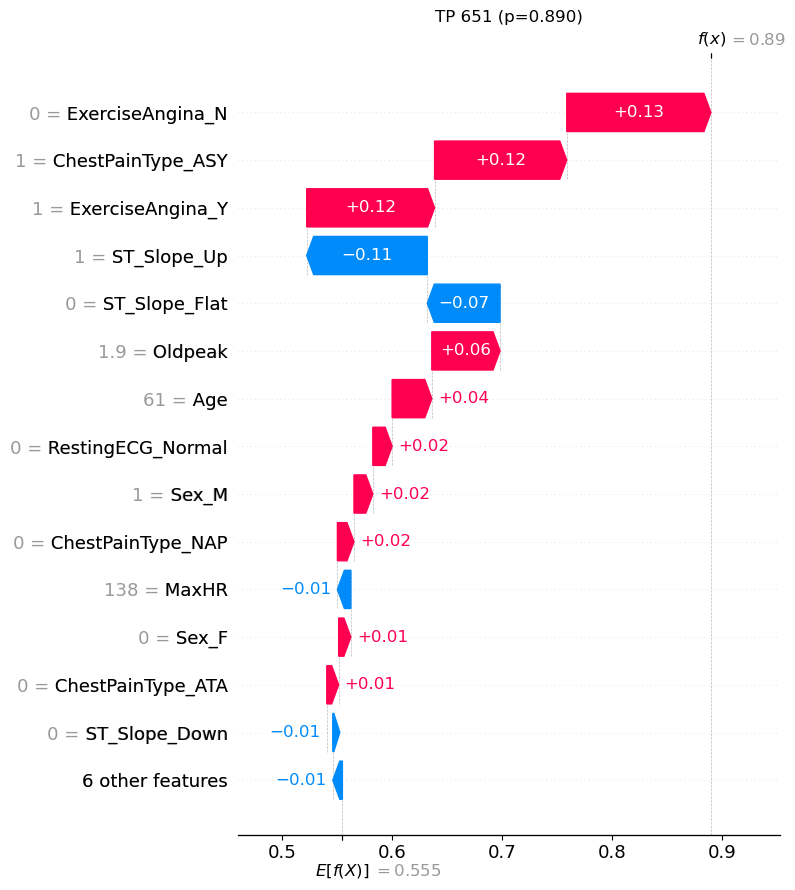

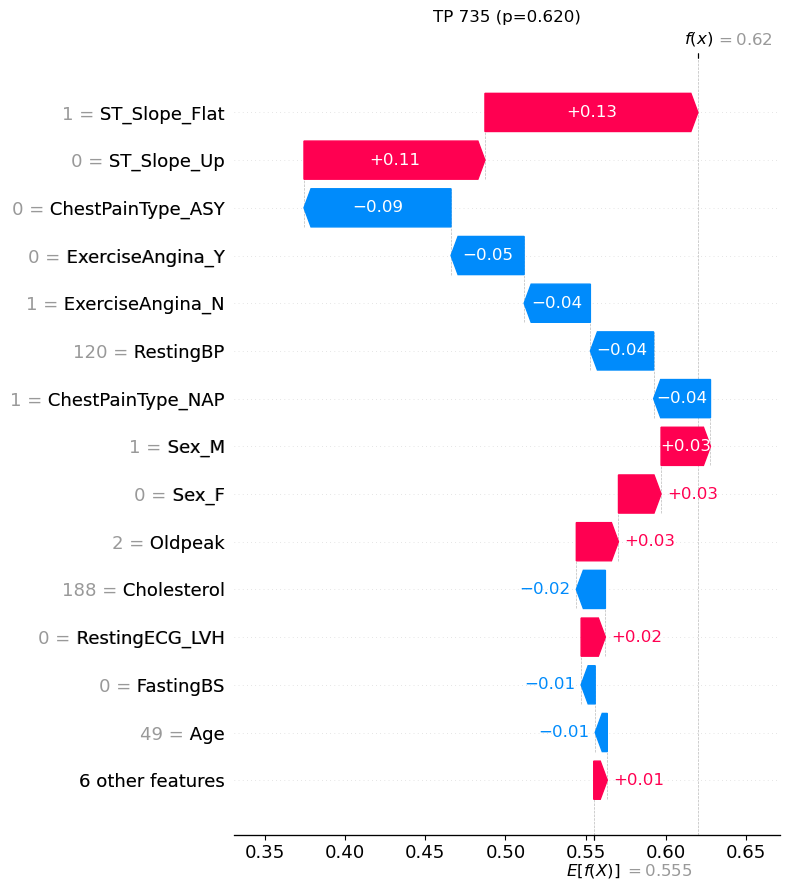

feature  FN_val  FN_SHAP  TP1_786_val  TP1_786_SHAP  \
0             Oldpeak     3.2    0.150          2.0         0.052   
1       ST_Slope_Flat     0.0   -0.111          1.0         0.123   
2         ST_Slope_Up     1.0   -0.098          0.0         0.105   
3   ChestPainType_ASY     0.0   -0.083          0.0        -0.094   
4               MaxHR   173.0   -0.048        146.0        -0.021   
5    ExerciseAngina_Y     0.0   -0.047          0.0        -0.039   
6    ExerciseAngina_N     1.0   -0.041          1.0        -0.049   
7                 Age    58.0    0.030         69.0         0.004   
8   ChestPainType_NAP     1.0   -0.029          1.0        -0.048   
9         Cholesterol   224.0   -0.027        254.0        -0.015   
10          RestingBP   132.0   -0.021        140.0         0.047   
11              Sex_M     1.0    0.010          1.0         0.020   
12              Sex_F     0.0    0.009          0.0         0.024   
13          FastingBS     0.0   -0.006          0.0        -0.007   
14  RestingECG_Normal     0.0    0.003          0.0         0.004   
15     RestingECG_LVH     1.0    0.001          1.0        -0.006   
16   ChestPainType_TA     0.0   -0.000          0.0         0.003   
17  ChestPainType_ATA     0.0    0.000          0.0         0.001   
18      RestingECG_ST     0.0    0.000          0.0        -0.003   
19      ST_Slope_Down     0.0   -0.000          0.0         0.001   

    TP2_651_val  TP2_651_SHAP  TP3_735_val  TP3_735_SHAP  meanTP_SHAP  \
0           1.9         0.062          2.0         0.026        0.047   
1           0.0        -0.066          1.0         0.133        0.063   
2           1.0        -0.110          0.0         0.113        0.036   
3           1.0         0.120          0.0        -0.092       -0.022   
4         138.0        -0.012        139.0         0.004       -0.010   
5           1.0         0.116          0.0        -0.046        0.011   
6           0.0         0.131          1.0        -0.041        0.014   
7          61.0         0.036         49.0        -0.008        0.011   
8           0.0         0.015          1.0        -0.035       -0.023   
9         207.0        -0.002        188.0        -0.018       -0.012   
10        140.0        -0.003        120.0        -0.039        0.002   
11          1.0         0.017          1.0         0.031        0.023   
12          0.0         0.011          0.0         0.027        0.021   
13          0.0        -0.005          0.0        -0.009       -0.007   
14          0.0         0.018          1.0         0.005        0.009   
15          1.0         0.003          0.0         0.015        0.004   
16          0.0         0.002          0.0        -0.001        0.002   
17          0.0         0.011          0.0         0.002        0.004   
18          0.0        -0.004          0.0        -0.001       -0.003   
19          0.0        -0.005          0.0        -0.000       -0.001   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                   0.103      0.103           1    763  
1                  -0.174      0.174          -1    763  
2                  -0.134      0.134          -1    763  
3                  -0.061      0.061          -1    763  
4                  -0.038      0.038          -1    763  
5                  -0.057      0.057          -1    763  
6                  -0.054      0.054          -1    763  
7                   0.020      0.020           1    763  
8                  -0.006      0.006          -1    763  
9                  -0.015      0.015          -1    763  
10                 -0.022      0.022          -1    763  
11                 -0.013      0.013          -1    763  
12                 -0.011      0.011          -1    763  
13                  0.001      0.001           1    763  
14                 -0.006      0.006          -1    763  
15                 -0.003      0.003          -1    763  
16                 -0.002      0.002        

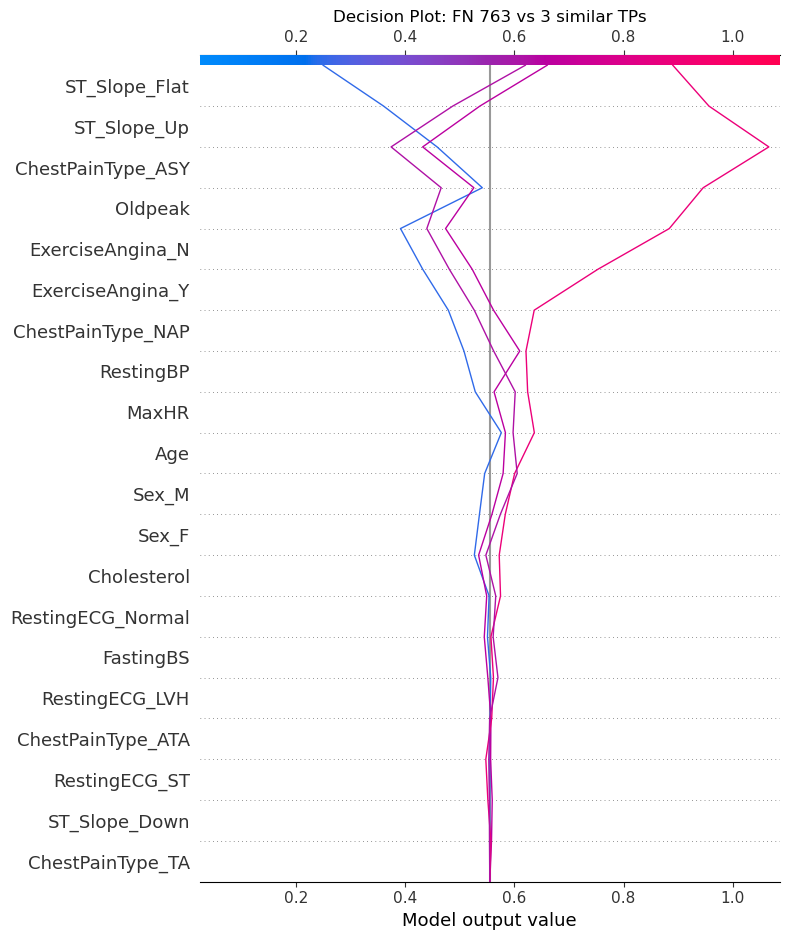

In [61]:
fn_id = 763

waterfall_table = make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[3]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   

matches = plot_decision_for_fn_group(fn_id, k=3)

## 6) FN_ID: 889

FN: 889 proba: 0.08


fn_id  tp_id  rank  distance  fn_proba  tp_proba
15    889    581     1  2.419694      0.08      0.74
16    889    735     2  2.772903      0.08      0.62
17    889    651     3  2.837886      0.08      0.89

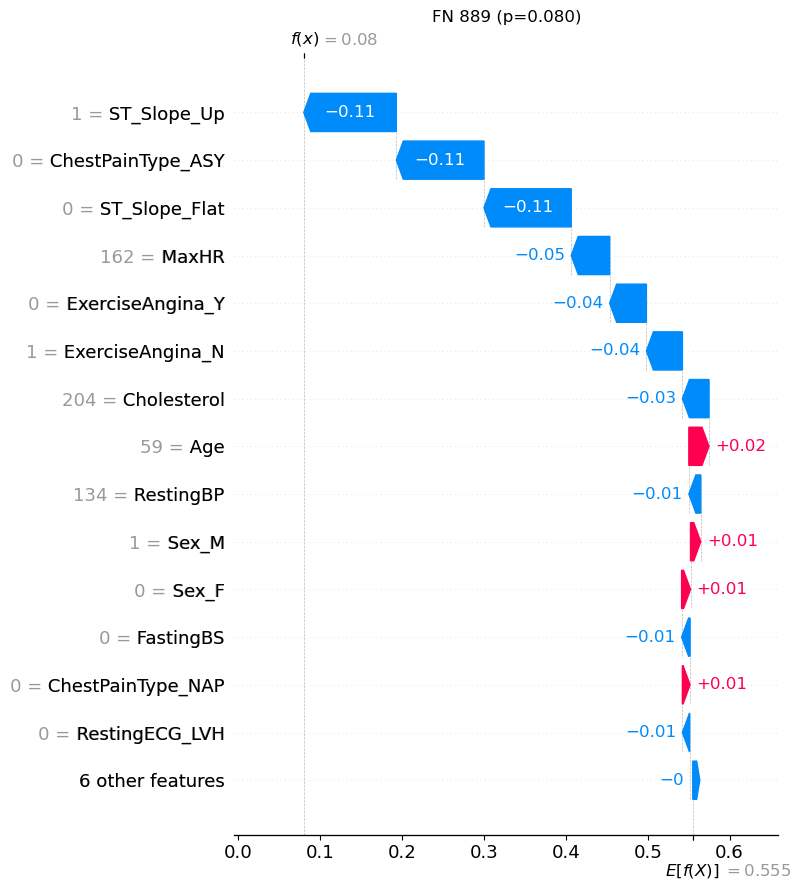

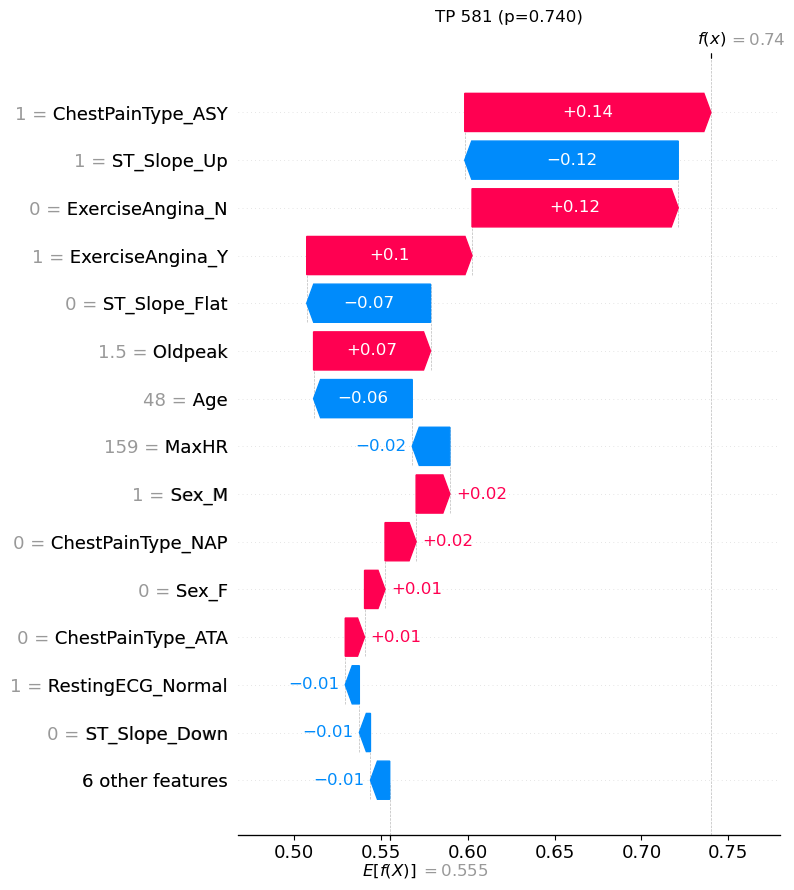

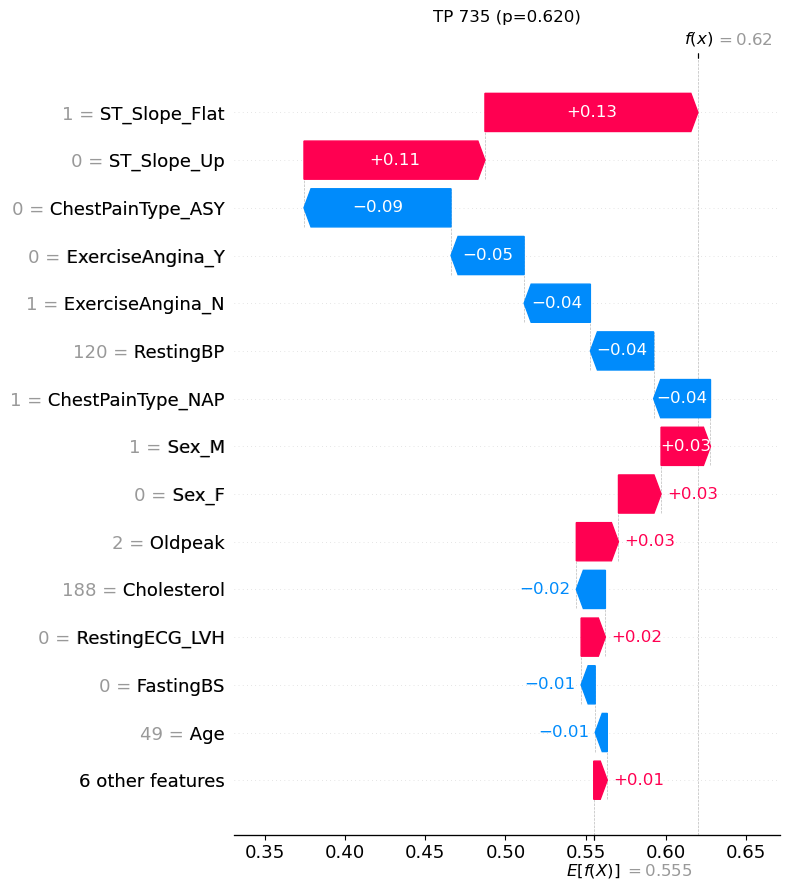

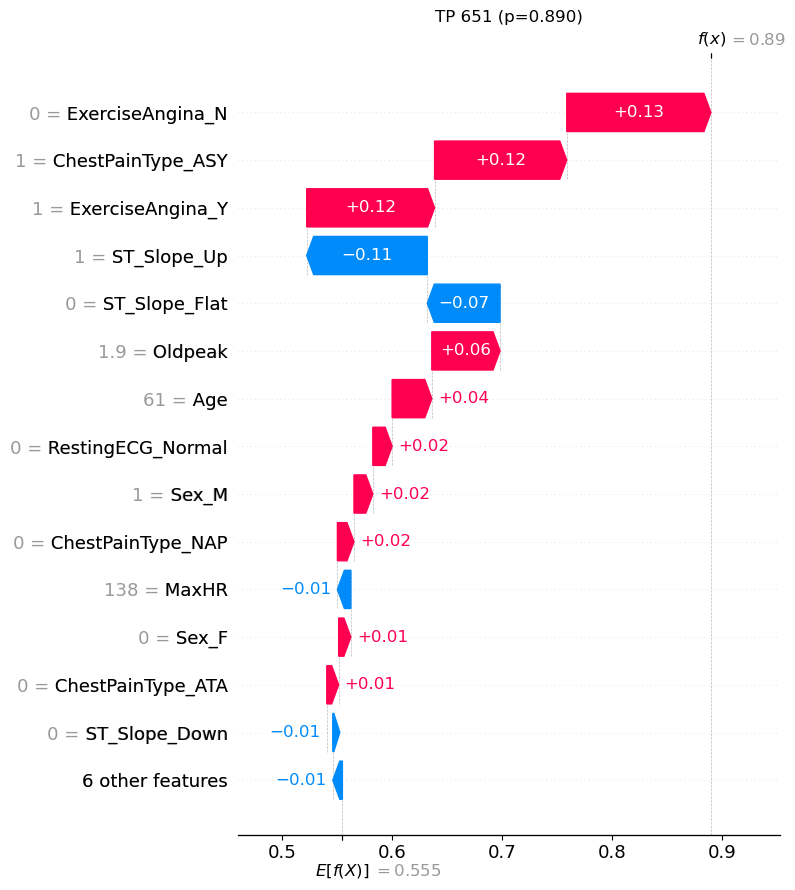

feature  FN_val  FN_SHAP  TP1_581_val  TP1_581_SHAP  \
0         ST_Slope_Up     1.0   -0.113          1.0        -0.123   
1   ChestPainType_ASY     0.0   -0.107          1.0         0.142   
2       ST_Slope_Flat     0.0   -0.107          0.0        -0.071   
3               MaxHR   162.0   -0.047        159.0        -0.022   
4    ExerciseAngina_Y     0.0   -0.045          1.0         0.095   
5    ExerciseAngina_N     1.0   -0.044          0.0         0.119   
6         Cholesterol   204.0   -0.032        208.0        -0.001   
7                 Age    59.0    0.025         48.0        -0.057   
8           RestingBP   134.0   -0.015        140.0        -0.006   
9               Sex_M     1.0    0.013          1.0         0.019   
10              Sex_F     0.0    0.011          0.0         0.012   
11          FastingBS     0.0   -0.010          0.0        -0.002   
12     RestingECG_LVH     0.0   -0.009          0.0        -0.002   
13  ChestPainType_NAP     0.0    0.009          0.0         0.018   
14  RestingECG_Normal     1.0   -0.008          1.0        -0.008   
15  ChestPainType_ATA     0.0    0.006          0.0         0.011   
16            Oldpeak     0.8    0.003          1.5         0.067   
17      RestingECG_ST     0.0   -0.002          0.0        -0.003   
18      ST_Slope_Down     0.0   -0.002          0.0        -0.006   
19   ChestPainType_TA     1.0   -0.000          0.0         0.002   

    TP2_735_val  TP2_735_SHAP  TP3_651_val  TP3_651_SHAP  meanTP_SHAP  \
0           0.0         0.113          1.0        -0.110       -0.040   
1           0.0        -0.092          1.0         0.120        0.057   
2           1.0         0.133          0.0        -0.066       -0.002   
3         139.0         0.004        138.0        -0.012       -0.010   
4           0.0        -0.046          1.0         0.116        0.055   
5           1.0        -0.041          0.0         0.131        0.069   
6         188.0        -0.018        207.0        -0.002       -0.007   
7          49.0        -0.008         61.0         0.036       -0.009   
8         120.0        -0.039        140.0        -0.003       -0.016   
9           1.0         0.031          1.0         0.017        0.022   
10          0.0         0.027          0.0         0.011        0.016   
11          0.0        -0.009          0.0        -0.005       -0.005   
12          0.0         0.015          1.0         0.003        0.006   
13          1.0        -0.035          0.0         0.015       -0.001   
14          1.0         0.005          0.0         0.018        0.005   
15          0.0         0.002          0.0         0.011        0.008   
16          2.0         0.026          1.9         0.062        0.052   
17          0.0        -0.001          0.0        -0.004       -0.003   
18          0.0        -0.000          0.0        -0.005       -0.004   
19          0.0        -0.001          0.0         0.002        0.001   

    Delta_FN_minus_meanTP  abs_delta  delta_sign  fn_id  
0                  -0.073      0.073          -1    889  
1                  -0.164      0.164          -1    889  
2                  -0.105      0.105          -1    889  
3                  -0.037      0.037          -1    889  
4                  -0.100      0.100          -1    889  
5                  -0.113      0.113          -1    889  
6                  -0.025      0.025          -1    889  
7                   0.034      0.034           1    889  
8                   0.001      0.001           1    889  
9                  -0.010      0.010          -1    889  
10                 -0.006      0.006          -1    889  
11                 -0.005      0.005          -1    889  
12                 -0.014      0.014          -1    889  
13                  0.010      0.010           1    889  
14                 -0.013      0.013          -1    889  
15                 -0.002      0.002          -1    889  
16                 -0.049      0.049        

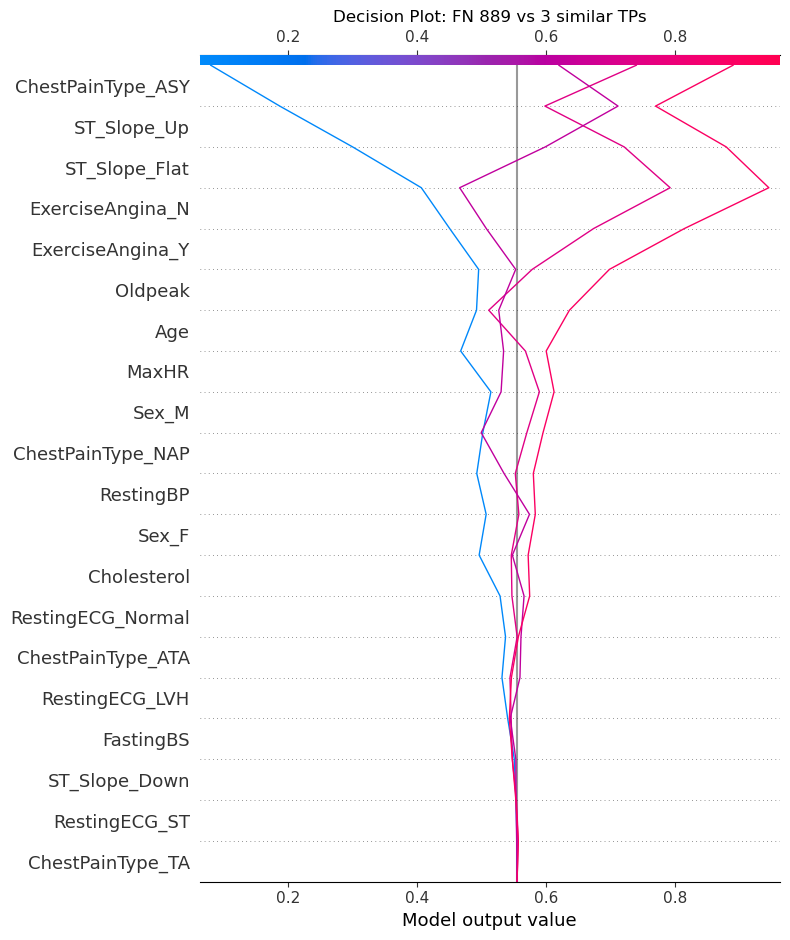

In [50]:
fn_id = 889

waterfall_table = make_waterfall_compare_table(fn_id, k=3)

fn_id_example = fn_cases.sort_values("y_proba").index[1]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   

matches = plot_decision_for_fn_group(fn_id, k=3)

## Entwicklung der Meta-Tabelle

In [25]:
def shap_row_for_index(sample_id, X_test_processed, shap_values_1):
    row_pos = X_test_processed.index.get_loc(sample_id)
    return pd.Series(shap_values_1[row_pos], index=X_test_processed.columns, name=sample_id)

def is_binary_ohe_feature(col_series: pd.Series) -> bool:
    s = col_series.dropna()
    if s.empty:
        return False
    uniq = set(np.unique(s.values))
    return uniq.issubset({0, 1, 0.0, 1.0})


# 1) Einzeltabelle pro FN: ALLE Features (FN vs mean(TPs))
#    Sortierung nach FN_SHAP absteigend (wie du wolltest)

def make_full_compare_table_for_fn(
    fn_id,
    knn_matches_df,
    X_test_processed,
    shap_values_1,
    k_neighbors=3,
    sort_by="FN_SHAP",          
    ascending=False
):
    # passende TPs holen
    matches = (knn_matches_df[knn_matches_df["fn_id"] == fn_id]
               .sort_values("rank")
               .head(k_neighbors))
    tp_ids = matches["tp_id"].tolist()

    # Werte: FN + TPs
    fn_vals = X_test_processed.loc[fn_id]
    tp_vals = X_test_processed.loc[tp_ids]                 # (k, n_features)
    mean_tp_vals = tp_vals.mean(axis=0)                    # (n_features)

    # SHAP: FN + TPs
    fn_shap = shap_row_for_index(fn_id, X_test_processed, shap_values_1)
    tp_shaps = pd.concat(
        [shap_row_for_index(tp_id, X_test_processed, shap_values_1) for tp_id in tp_ids],
        axis=1
    )
    mean_tp_shap = tp_shaps.mean(axis=1)

    delta = fn_shap - mean_tp_shap

    df = pd.DataFrame({
        "feature": X_test_processed.columns,
        "FN_val": fn_vals.values,
        "meanTP_val": mean_tp_vals.values,
        "FN_SHAP": fn_shap.values,
        "meanTP_SHAP": mean_tp_shap.values,
        "Delta_FN_minus_meanTP": delta.values,
        "abs_FN_SHAP": np.abs(fn_shap.values),
        "abs_Delta": np.abs(delta.values),
        "fn_id": fn_id
    })

    
    df["FN_SHAP"] = df["FN_SHAP"].astype(float).round(3)
    df["meanTP_SHAP"] = df["meanTP_SHAP"].astype(float).round(3)
    df["Delta_FN_minus_meanTP"] = df["Delta_FN_minus_meanTP"].astype(float).round(3)

    df["FN_val"] = df["FN_val"].astype(float)
    df["meanTP_val"] = df["meanTP_val"].astype(float)

    # Sortierung
    if sort_by == "abs_FN_SHAP":
        df = df.sort_values("abs_FN_SHAP", ascending=ascending).reset_index(drop=True)
    else:
        df = df.sort_values("FN_SHAP", ascending=ascending).reset_index(drop=True)

    return df, matches, tp_ids

# 2) Meta-Tabelle über alle FNs 
#    - OHE/Binary: getrennte Zeilen Feature=0 / Feature=1
#    - Numerisch: eine Zeile pro Feature


def build_meta_table_over_all_fns_no_mixing(
    fn_ids,
    knn_matches_df,
    X_test_processed,
    shap_values_1,
    k_neighbors=3
):
    # welche Features sind binary/ohe?
    binary_mask = {col: is_binary_ohe_feature(X_test_processed[col]) for col in X_test_processed.columns}

    all_rows = []
    for fn_id in fn_ids:
        per_fn_df, matches, tp_ids = make_full_compare_table_for_fn(
            fn_id=fn_id,
            knn_matches_df=knn_matches_df,
            X_test_processed=X_test_processed,
            shap_values_1=shap_values_1,
            k_neighbors=k_neighbors,
            sort_by="FN_SHAP",
            ascending=False
        )

        # Key bauen: bei binary => "feature=FN_val" sonst nur "feature"
        # dadurch werden z.B. ST_Slope_Up=0 und ST_Slope_Up=1 NICHT vermischt
        def make_key(row):
            feat = row["feature"]
            if binary_mask.get(feat, False):
                # FN_val kann float sein -> sauber zu int
                v = int(round(float(row["FN_val"])))
                return f"{feat}={v}"
            else:
                return feat

        per_fn_df["meta_key"] = per_fn_df.apply(make_key, axis=1)

        # Vorzeichen für Konsistenz
        per_fn_df["delta_sign"] = np.sign(per_fn_df["Delta_FN_minus_meanTP"].astype(float)).astype(int)

        all_rows.append(per_fn_df)

    long_df = pd.concat(all_rows, ignore_index=True)

    # sign consistency
    def sign_consistency(x: pd.Series) -> float:
        counts = x.value_counts()
        return float(counts.max() / counts.sum()) if counts.sum() else np.nan

    meta = (long_df.groupby(["meta_key"], as_index=False)
            .agg(
                feature=("feature", "first"),
                is_binary=("feature", lambda s: bool(binary_mask.get(s.iloc[0], False))),

                # wie oft kommt es in den 6 FN-Fällen vor?
                freq=("fn_id", "nunique"),

                # Werte 
                mean_FN_val=("FN_val", "mean"),
                mean_meanTP_val=("meanTP_val", "mean"),

                # SHAP / Delta Kennzahlen
                mean_FN_SHAP=("FN_SHAP", "mean"),
                mean_meanTP_SHAP=("meanTP_SHAP", "mean"),
                mean_delta=("Delta_FN_minus_meanTP", "mean"),
                mean_abs_delta=("Delta_FN_minus_meanTP", lambda x: np.mean(np.abs(x.astype(float)))),

                sign_consistency=("delta_sign", sign_consistency),
            ))

    # Formatierung
    n_fns = len(fn_ids)
    meta["freq"] = meta["freq"].astype(int).astype(str) + f"/{n_fns}"
    meta["sign_consistency"] = (meta["sign_consistency"] * 100).round(0).astype(int).astype(str) + " %"

    # runden
    for c in ["mean_FN_val", "mean_meanTP_val", "mean_FN_SHAP", "mean_meanTP_SHAP", "mean_delta", "mean_abs_delta"]:
        meta[c] = meta[c].astype(float).round(3)

    meta = meta.sort_values("mean_abs_delta", ascending=False).reset_index(drop=True)

    return meta, long_df

Nun werden die bisherigen **lokalen FN–TP-Vergleiche** von der Einzelfallebene auf eine **strukturierte, übergreifende Analyse** erweitert.

Zunächst wird für einen einzelnen **False-Negative-Fall** eine  
**vollständige Vergleichstabelle** erzeugt, die für **alle Features**

- die Feature-Werte und SHAP-Beiträge des FN
- den **durchschnittlichen SHAP-Beiträgen** seiner *k* ähnlichsten **True Positives**

gegenüberstellt. Dadurch wird sichtbar,

- **welche Features den FN systematisch in Richtung „gesund“ drücken**,  
- verglichen mit sehr ähnlichen, korrekt klassifizierten Fällen.

Darauf aufbauend werden diese Vergleichstabellen über **alle False-Negative-Fälle aggregiert**.

Dabei gilt:

- **Binäre (One-Hot-kodierte) Features**
  - werden sauber nach Ausprägung (**0 / 1**) getrennt,
- **Numerische Features**
  - werden **nicht vermischt**, sondern getrennt behandelt.

Das Ergebnis ist eine **Meta-Tabelle**, die zeigt,

- welche Merkmale **über mehrere False Negatives hinweg**
- **konsistent zur Fehlklassifikation beitragen**,

inklusive

- **Häufigkeit** des Auftretens,
- **mittlerem SHAP-Effekt**,
- und **Vorzeichenstabilität**.

Diese Aggregation bildet die Brücke von **lokaler XAI**  zu Anzeige von **systematischen Modellschwächen**.

## Aggregierte XAI-Analyse über alle False-Negative-Fälle

In [26]:
fn_ids = fn_cases.index.tolist()     # die 6 FN-IDs
K_NEIGHBORS = 3

meta_table, long_table = build_meta_table_over_all_fns_no_mixing(
    fn_ids=fn_ids,
    knn_matches_df=knn_matches_df,
    X_test_processed=X_test_processed,
    shap_values_1=shap_values_1,
    k_neighbors=K_NEIGHBORS
)

display(meta_table)

meta_key            feature  is_binary freq  mean_FN_val  \
0       ST_Slope_Flat=0      ST_Slope_Flat       True  5/6        0.000   
1         ST_Slope_Up=1        ST_Slope_Up       True  5/6        1.000   
2               Sex_F=1              Sex_F       True  1/6        1.000   
3               Sex_M=0              Sex_M       True  1/6        0.000   
4   ChestPainType_ASY=0  ChestPainType_ASY       True  6/6        0.000   
5               Oldpeak            Oldpeak      False  6/6        1.333   
6    ExerciseAngina_N=1   ExerciseAngina_N       True  6/6        1.000   
7    ExerciseAngina_Y=0   ExerciseAngina_Y       True  6/6        0.000   
8                 MaxHR              MaxHR      False  6/6      169.667   
9             RestingBP          RestingBP      False  6/6      142.333   
10          Cholesterol        Cholesterol      False  6/6      189.000   
11      ST_Slope_Flat=1      ST_Slope_Flat       True  1/6        1.000   
12  ChestPainType_ATA=1  ChestPainType_ATA       True  1/6        1.000   
13                  Age                Age      False  6/6       53.167   
14        ST_Slope_Up=0        ST_Slope_Up       True  1/6        0.000   
15  ChestPainType_NAP=1  ChestPainType_NAP       True  4/6        1.000   
16     RestingECG_LVH=1     RestingECG_LVH       True  2/6        1.000   
17              Sex_M=1              Sex_M       True  5/6        1.000   
18          FastingBS=0          FastingBS       True  6/6        0.000   
19              Sex_F=0              Sex_F       True  5/6        0.000   
20     RestingECG_LVH=0     RestingECG_LVH       True  4/6        0.000   
21  ChestPainType_NAP=0  ChestPainType_NAP       True  2/6        0.000   
22  RestingECG_Normal=1  RestingECG_Normal       True  3/6        1.000   
23  RestingECG_Normal=0  RestingECG_Normal       True  3/6        0.000   
24  ChestPainType_ATA=0  ChestPainType_ATA       True  5/6        0.000   
25   ChestPainType_TA=0   ChestPainType_TA       True  5/6        0.000   
26      RestingECG_ST=1      RestingECG_ST       True  1/6        1.000   
27      ST_Slope_Down=0      ST_Slope_Down       True  6/6        0.000   
28      RestingECG_ST=0      RestingECG_ST       True  5/6        0.000   
29   ChestPainType_TA=1   ChestPainType_TA       True  1/6        1.000   

    mean_meanTP_val  mean_FN_SHAP  mean_meanTP_SHAP  mean_delta  \
0             0.600        -0.109             0.048      -0.156   
1             0.400        -0.106             0.023      -0.129   
2             0.000        -0.086             0.021      -0.107   
3             1.000        -0.082             0.023      -0.106   
4             0.500        -0.084             0.008      -0.092   
5             1.733         0.036             0.039      -0.003   
6             0.611        -0.036             0.016      -0.051   
7             0.389        -0.038             0.010      -0.048   
8           140.722        -0.051            -0.003      -0.048   
9           134.333         0.010            -0.010       0.020   
10          184.389         0.002             0.002       0.000   
11            1.000         0.105             0.129      -0.024   
12            0.333        -0.020             0.001      -0.021   
13           52.778        -0.005            -0.002      -0.002   
14            0.000         0.090             0.110      -0.019   
15            0.500        -0.030            -0.012      -0.017   
16            0.500         0.016             0.005       0.011   
17            1.000         0.010             0.021      -0.012   
18            0.111        -0.012            -0.002      -0.011   
19            0.000         0.008             0.017      -0.009   
20            0.083        -0.002             0.007      -0.008   
21            0.167         0.009             0.006       0.003   
22            0.889        -0.004             0.003      -0.007   
23            0.333         0.007             0.004       0.003   
24            

Die lokale XAI-Analyse einzelner False-Negative-Fälle liefert wertvolle Einblicke in konkrete Fehlentscheidungen des Modells. Eine vollständige, detaillierte Interpretation aller sechs False Negatives würde jedoch zu starken Redundanzen führen, da sich viele Muster wiederholen und einzelne Effekte nur schwer vergleichbar wären.

Stattdessen wird im Folgenden eine **aggregierte Meta-Tabelle** betrachtet, die die lokalen SHAP-Ergebnisse **über alle sechs False-Negative-Fälle hinweg zusammenfasst**. Ziel dieser Aggregation ist es, **systematische Kippfaktoren** zu identifizieren, also Merkmale, die über mehrere Fälle hinweg konsistent zur Fehlklassifikation beitragen.

Um eine Vermischung unterschiedlicher Feature-Zustände zu vermeiden, werden **binäre bzw. One-Hot-Encoded Features getrennt nach ihrem tatsächlichen Wert (0 oder 1)** aggregiert. Die Meta-Tabelle basiert auf vollständigen lokalen Vergleichstabellen (False Negative vs. Mittelwert der jeweils drei ähnlichsten True Positives) und fasst deren Informationen featureweise zusammen.


### Bedeutung der Spalten in der Meta-Tabelle

Im Folgenden werden die einzelnen Spalten der Meta-Tabelle erläutert:

- **`feature`**  
  Name des betrachteten Features. Bei binären Features entspricht dieser der ursprünglichen Spaltenbezeichnung aus dem Modellinput.

- **`freq`**  
  Anzahl der False-Negative-Fälle, in denen dieses Feature (bzw. dieser Feature-Zustand) auftritt. Die Angabe erfolgt relativ zur Gesamtzahl der False Negatives. Sprich wenn das Feature ST_Slope_Flat=0 eine freq von `5/6` hat bedeutet das, dass in  5 von den insgesamt 6 False-Negative-Fällen das Feature den Wert = 0 hatte.
  
- **`mean_FN_val`**  
  Durchschnittlicher Feature-Wert über alle betrachteten False-Negative-Fälle.  

- **`mean_meanTP_val`**  
  Durchschnittlicher Feature-Wert der jeweils zugeordneten True-Positive-Vergleichsfälle. Dieser Wert dient als Referenz, um zu beurteilen, **ob sich False Negatives systematisch von ähnlichen True Positives unterscheiden**.

- **`mean_FN_SHAP`**  
  Mittlerer SHAP-Wert des Features über alle False-Negative-Fälle. Er beschreibt, **in welche Richtung und mit welcher Stärke** das Feature die Modellvorhersage bei False Negatives beeinflusst.

- **`mean_meanTP_SHAP`**  
  Durchschnittlicher SHAP-Wert desselben Features bei den zugehörigen True-Positive-Fällen. Dieser Wert zeigt, wie das Modell dasselbe Feature **bei korrekt klassifizierten, ähnlichen Patienten nutzt**.

- **`mean_delta`**

 $$
\text{mean\_delta}
= \frac{1}{N} \sum_{i=1}^{N}
\left( \text{FN\_SHAP}_i - \overline{\text{TP\_SHAP}_i} \right)
$$

  Der mittlere Delta-Wert beschreibt die durchschnittliche Differenz zwischen dem SHAP-Wert eines Features bei False Negatives und dem mittleren SHAP-Wert desselben Features bei den zugehörigen True-Positive-Fällen  
  
  Das Vorzeichen von `mean_delta` gibt die **Richtung des systematischen Effekts** im Mittel an:
  - ein **negativer Wert** bedeutet, dass das Feature die Vorhersage bei False Negatives im Mittel stärker in Richtung „gesund“ verschiebt als bei ähnlichen True Positives,
  - ein **positiver Wert** entsprechend stärker in Richtung „krank“.

  `mean_delta` beantwortet somit die Frage, **in welche Richtung ein Feature zur Fehlklassifikation im Durchschnitt beiträgt**, sagt jedoch noch nichts darüber aus, **wie stark** dieser Effekt ist.

- **`mean_abs_delta`**

$$
\text{mean\_abs\_delta}
= \frac{1}{N} \sum_{i=1}^{N}
\left| \text{FN\_SHAP}_i - \overline{\text{TP\_SHAP}_i} \right|
$$


  Der Wert `mean_abs_delta` ist der Mittelwert der **absoluten** Delta-Werte über alle betrachteten False-Negative-Fälle:

  Diese Kennzahl misst **die Stärke der Abweichung zwischen False Negatives und vergleichbaren True Positives**, unabhängig von der Richtung.  
  Sie beantwortet die zentrale Frage der Meta-Analyse:

  > *Wie stark unterscheidet sich die Nutzung dieses Features bei Fehlklassifikationen von der Nutzung bei korrekten Klassifikationen?*

  `mean_abs_delta` ist daher die **zentrale Bewertungssmetrik** der Meta-Tabelle. Features mit hohen Werten weisen auf **systematische Modellinkonsistenzen** hin: Das Modell behandelt sie bei sehr ähnlichen Patienten deutlich unterschiedlich, ein typisches Muster für Kippfaktoren von Fehlentscheidungen.


- **`sign_consistency`**

Die Kennzahl **sign_consistency** beschreibt den **Anteil der False-Negative-Fälle**,  
in denen das berechnete **Delta** dasselbe Vorzeichen aufweist.  
Sie gibt damit an, in wie vielen False-Negative-Fällen das **Mean_Delta**  
in **dieselbe Richtung** wirkt.

Diese Kennzahl misst **nicht die Stärke**, sondern die **Stabilität der Richtung**  
eines Feature-Effekts über mehrere Fehlklassifikationen hinweg.

**Mechanische Berechnung**

Für eine gegebene Meta-Zeile (z. B. *RestingECG_LVH = 1*) wird wie folgt vorgegangen:

- Es werden alle zugehörigen **Delta-Werte** betrachtet  
  (also alle False-Negative-Fälle, in denen dieses Feature auftritt).
- Für jedes Delta wird ausschließlich geprüft, ob es
  - **positiv** oder
  - **negativ**
  ist.
- Anschließend wird gezählt, **welches Vorzeichen häufiger vorkommt**.
- Der Anteil dieses Mehrheits-Vorzeichens entspricht der **sign_consistency**.

**Beispiel**

Angenommen, ein Feature tritt in **5 False-Negative-Fällen** auf  
und die berechneten Delta-Werte lauten:

- −0.10  
- −0.12  
- −0.08  
- +0.02  
- −0.06  

Dann ergibt sich:

- negative Deltas: **4**
- positive Deltas: **1**

Die **sign_consistency** beträgt in diesem Fall **80 %**. Das bedeutet, dass in etwa **80 % der relevanten False-Negative-Fälle** das Feature **gerichtet in dieselbe Richtung** wirkt.


## Auswahl- und Bewertungslogik der Meta-Analyse

Ziel der vorliegenden Meta-Analyse ist es **nicht**, allgemein wichtige Features des Modells zu identifizieren, sondern jene Merkmale herauszuarbeiten,  **die systematisch zur Entstehung von False-Negative-Fehlklassifikationen beitragen**.

Im Fokus steht damit nicht die generelle Modellwichtigkeit einzelner Variablen, sondern die Frage:

> **Wodurch unterscheiden sich False Negatives konsistent von sehr ähnlichen, korrekt klassifizierten True Positives?**


### Grundidee der Bewertungslogik

Entscheidend ist **nicht**, wie stark ein Feature im Durchschnitt bei False-Negative-Fällen wirkt, sondern **wie stark sich seine Nutzung bei Fehlklassifikationen von der Nutzung bei vergleichbaren korrekt klassifizierten Fällen unterscheidet**. Genau auf diesen Unterschied zielt die hier verwendete Bewertungslogik ab.

### Zentrales Auswahlkriterium: mean_abs_delta

Das zentrale Auswahlkriterium der Meta-Analyse ist der **mean_abs_delta**-Wert.

Er misst direkt,

- wie stark sich die SHAP-Werte eines Features bei False Negatives  
- von den **mittleren SHAP-Werten desselben Features bei den jeweils zugeordneten True-Positive-Nachbarn** unterscheiden.

Damit quantifiziert **mean_abs_delta**

- die **Stärke der Abweichung** zwischen Fehl- und Nicht-Fehlentscheidungen,
- **unabhängig von deren Richtung**.

Features mit hohen **mean_abs_delta**-Werten werden vom Modell bei False Negatives deutlich anders genutzt als bei vergleichbaren True Positives  
und stellen damit **potenzielle Kippfaktoren von Fehlentscheidungen** dar.


### Abgrenzung zu mean_FN_SHAP

Andere naheliegende Kennzahlen wie **mean_FN_SHAP** sind hierfür nur eingeschränkt geeignet, denn**mean_FN_SHAP** beschreibt lediglich,

- wie ein Feature **im Durchschnitt bei False Negatives wirkt**,

lässt jedoch offen,

- ob dieses Verhalten **spezifisch für Fehlklassifikationen** ist  
- oder in gleicher Weise auch bei korrekt klassifizierten Fällen auftritt.

Ein Feature kann rein theoretisch:

- bei False Negatives einen starken SHAP-Effekt zeigen,
- aber bei True Positives einen **sehr ähnlichen Effekt** haben.

In diesem Fall ist das Feature zwar relevant für die Modellentscheidung insgesamt, **erklärt jedoch nicht, warum es zu einer Fehlklassifikation kommt**.

**mean_FN_SHAP allein kann diese Unterscheidung nicht leisten.**


### Rolle von mean_delta

Die Kennzahl **mean_delta** erweitert diese Betrachtung, indem sie

- den durchschnittlichen Unterschied zwischen FN-SHAP und dem mittleren TP-SHAP beschreibt
- und damit angibt, **in welche Richtung ein Feature im Mittel zur Fehlklassifikation beiträgt**.

Allerdings ist **mean_delta** anfällig für gegenläufige Effekte:

- Wirkt ein Feature in manchen False-Negative-Fällen stärker in Richtung „gesund“
- und in anderen stärker in Richtung „krank“,

können sich diese Effekte **gegenseitig aufheben**.

In solchen Fällen ist **mean_delta nahe null**, obwohl das Feature in einzelnen Fällen einen erheblichen Einfluss auf die Modellentscheidung hat.

**mean_delta eignet sich daher primär zur inhaltlichen Einordnung der Richtung**, nicht jedoch als Hauptkriterium für die Auswahl relevanter Fehlfaktoren.

Diese Einschränkungen werden durch **mean_abs_delta** überwunden.


### Ergänzende Bewertung: sign_consistency

Ergänzend wird die Kennzahl **sign_consistency** berücksichtigt, um

- die **Stabilität der Richtung** dieses Effekts zu bewerten.

**sign_consistency** gibt an,

- in welchem Anteil der betrachteten False-Negative-Fälle  
- die dominante Richtung der Delta-Werte auftritt.

Interpretation:

- **Hohe sign_consistency** (z. B. 100 %)  
  → stabiler, reproduzierbarer Fehlmechanismus  
- **Niedrigere Werte**  
  → kontextabhängige oder interaktionsgetriebene Effekte

**sign_consistency dient als Qualitätsmaß für mean_abs_delta**:  

Während **mean_abs_delta** zeigt, *wie stark* ein Feature zur Fehlklassifikation beiträgt, zeigt **sign_consistency**, *wie verlässlich* diese Wirkung ist.


### Berücksichtigung der Häufigkeit (freq)

Schließlich wird die Häufigkeit des Auftretens (**freq**) eines Feature-Zustands berücksichtigt.

- Features, die nur in einzelnen False-Negative-Fällen auftreten,  
  können zwar interessante Einzelfall- oder Fairness-Aspekte aufweisen,
- bieten jedoch nur **begrenzten Hebel für eine globale Reduktion von False Negatives**.



## Zentrale Kippfaktoren der False-Negative-Fehlklassifikationen

Auf Basis der zuvor definierten Kriterien stechen insbesondere Merkmale aus dem Bereich der **ST-Segment-Charakteristika** hervor.


### Dominanter Kippfaktor: ST_Slope_Flat = 0

Das Feature **ST_Slope_Flat = 0** weist

- den **höchsten mean_abs_delta-Wert** der gesamten Meta-Tabelle auf,
- tritt in **fünf von sechs False-Negative-Fällen** auf,
- und zeigt einen **vollständig stabilen Effekt**  
  (**sign_consistency = 100 %**).

Der Effekt verschiebt die Modellentscheidung bei False Negatives konsistent in Richtung der falschen Klasse („gesund“). Dies deutet auf einen **systematischen Fehlmechanismus** hin, bei dem das Fehlen eines flachen ST-Segments vom Modell **zu stark entlastend interpretiert wird**.


### Strukturell ähnlicher Effekt: ST_Slope_Up = 1

Ein sehr ähnliches Muster zeigt sich für **ST_Slope_Up = 1**:

- Auftreten in **fünf von sechs False-Negative-Fällen**,
- **hoher mean_abs_delta-Wert**,
- **vollständig stabile Richtung** des Effekts.

In der gemeinsamen Betrachtung sprechen diese Ergebnisse für eine **strukturelle Fehlgewichtung der ST-Slope-Kodierung**, die bei bestimmten Konstellationen zu einer **systematischen Unterschätzung des Krankheitsrisikos** führt.


### Robuster kategorialer Fehlmechanismus: ChestPainType_ASY = 0

Ebenfalls auffällig ist **ChestPainType_ASY = 0**, das

- in **allen sechs False-Negative-Fällen** vorliegt,
- einen etwas geringeren **mean_abs_delta** als die ST-Slope-Features aufweist,
- jedoch einen **vollständig stabilen und konsistent negativen Effekt** zeigt.

Das Modell nutzt das **Fehlen asymptomatischer Brustschmerzen** bei False Negatives deutlich anders als bei vergleichbaren True Positives. Dies weist auf einen **weiteren robusten Fehlmechanismus** hin.


### Konsistentes Begleitmuster: ExerciseAngina

Auch **ExerciseAngina_N = 1** bzw. komplementär **ExerciseAngina_Y = 0** zeigen ein konsistentes Muster:

- Auftreten in **allen False-Negative-Fällen**,
- **mittelhohe mean_abs_delta-Werte**,
- **überwiegend stabile Richtung** des Effekts.

Das **Fehlen von Angina pectoris** wird bei False Negatives im Vergleich zu True Positives tendenziell **zu stark entlastend gewichtet**, was gut in das Gesamtbild der identifizierten Fehlmechanismen passt.


### Relevanter numerischer Hebel: MaxHR

Unter den numerischen Features sticht insbesondere **MaxHR** hervor:

- moderater, aber **vollständig stabiler mean_abs_delta-Wert**,
- Auftreten in **allen False-Negative-Fällen**.

Die False Negatives zeigen im Mittel **höhere MaxHR-Werte** als die zugehörigen True Positives. Dieser Effekt wird vom Modell offenbar **zu stark als entlastendes Signal interpretiert**.

Aufgrund seiner **Stabilität und Häufigkeit** stellt MaxHR einen **relevanten sekundären Hebel** für die Reduktion von False Negatives dar.


### Warum bestimmte Features nicht priorisiert wurden

Andere Features wie

- **Cholesterin**,
- **Resting Blood Pressure**,
- **Alter**

zeigen nur **sehr geringe mean_abs_delta-Werte**.

Obwohl diese Variablen medizinisch relevant sein können, spielen sie im konkreten Vergleich zwischen False Negatives und ähnlichen True Positives  
für die Modellentscheidung eine **untergeordnete Rolle**.

Besonders deutlich wird dies bei **ST_Slope_Down = 0**:

- trotz hoher medizinischer Relevanz,
- nahezu **kein Unterschied im FN-vs.-TP-Vergleich**,
- vom Modell in diesen Fällen **faktisch ignoriert**.


### Einzelfall-Effekte: Sex_F = 1 / Sex_M = 0

Auffällig sind zwar die relativ hohen **mean_abs_delta-Werte** für

- **Sex_F = 1**
- **Sex_M = 0**,

diese treten jedoch jeweils nur in **einem einzigen False-Negative-Fall** auf  
(**freq = 1/6**).

Es handelt sich damit um **Einzelfall-Effekte**, die zwar als potenzielle **Bias- oder Fairness-Indikatoren** relevant sind, jedoch **keinen robusten, generalisierbaren Ansatzpunkt** für eine systematische Verbesserung des **F2-Scores** bieten. Aus diesem Grund wurden diese Merkmale bewusst **nicht als primäre Kippfaktoren** ausgewählt.


### Zusammenfassende Prioritätenliste für die F2-Optimierung

Basierend auf der aggregierten XAI-Analyse ergeben sich folgende Features als wichtigste Ansatzpunkte zur Reduktion von False Negatives und zur Verbesserung des **F2-Scores**:

1. **ST_Slope_Flat = 0**
2. **ST_Slope_Up = 1**
3. **ChestPainType_ASY = 0**
4. **MaxHR**
5. **ExerciseAngina_N = 1 / ExerciseAngina_Y = 0**

Diese Merkmale zeigen **starke**, **häufige** und **überwiegend stabile** Unterschiede zwischen False Negatives und vergleichbaren True Positives und sollten daher bei weiteren Modellanpassungen (z. B. Class-Weighting, Schwellenwertanpassung, Feature-Interaktionen oder gezieltem Feature-Engineering)  
**prioritär berücksichtigt** werden.

---

## Einordnung der LIME-Analyse im Kontext der SHAP-basierten Fehleranalyse

Die vorliegende Arbeit stützt sich primär auf eine umfangreiche **SHAP-basierte Analyse** zur systematischen Untersuchung von **False-Negative-Fehlklassifikationen**.  
SHAP ermöglicht dabei eine

- konsistente,
- vergleichbare
- und aggregierbare

Quantifizierung von Feature-Effekten und bildet somit die **methodische Grundlage** für die Identifikation stabiler Fehlmechanismen im Modell.


### Rolle von LIME innerhalb der Analyse

Ergänzend zu dieser quantitativen Analyse wird im Folgenden zusätzlich das Verfahren **LIME (Local Interpretable Model-agnostic Explanations)** eingesetzt.

Ziel der LIME-Analyse ist dabei **nicht**,

- die SHAP-Ergebnisse zu ersetzen,
- oder die Analyse um eine weitere aggregierte Metrik zu erweitern.

Vielmehr dient LIME als **lokales, modellagnostisches Erklärungsverfahren**, das es erlaubt,

- die Modellentscheidung für einen **einzelnen ausgewählten False-Negative-Fall**
- sowie dessen **ähnlichste korrekt klassifizierte Gegenbeispiele**

anschaulich nachzuvollziehen.


### Methodischer Mehrwert der LIME-Analyse

Durch die **lokale Approximation des Modells** in der unmittelbaren Umgebung eines konkreten Datenpunkts ermöglicht LIME eine

- **intuitive**
- und **beispielhafte**

Illustration der zuvor identifizierten Fehlmechanismen.

Insbesondere eignet sich LIME dazu, den in der SHAP-Analyse beobachteten **Richtungswechsel einzelner Features** zwischen False Negatives und ähnlichen True Positives auf **Einzelfallebene sichtbar zu machen**.


### Bewusster Verzicht auf Aggregation

Eine Aggregation der LIME-Gewichte über mehrere Fälle hinweg wird bewusst **nicht vorgenommen**, da

- LIME-Erklärungen auf **lokalen Approximationen** beruhen
- und ihre Koeffizienten **nicht fallübergreifend vergleichbar** sind.

Die LIME-Analyse dient daher **ausschließlich der exemplarischen Illustration** der zuvor mittels SHAP identifizierten Fehlmechanismen.

## Entwicklung lokale LIME-Erklärungen für FN- und TP-Fälle

In [58]:
def make_predict_proba_df_wrapper(model, feature_names):
    feature_names = list(feature_names)

    def predict_proba_df(X):
        if isinstance(X, pd.DataFrame):
            X_df = X.copy()
            if list(X_df.columns) != feature_names:
                X_df = X_df[feature_names]
        else:
            X_df = pd.DataFrame(X, columns=feature_names)
        return model.predict_proba(X_df)

    return predict_proba_df

lime_explainer = LimeTabularExplainer(
    training_data=X_train_processed.values,
    feature_names=X_train_processed.columns.tolist(),
    class_names=["gesund (0)", "krank (1)"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)


def explain_with_lime_single_run(
    sample_id,
    X_test_processed,
    rf_model,
    lime_explainer,
    num_features=12,
    n_samples=5000
):
    feature_names = X_test_processed.columns.tolist()
    predict_fn = make_predict_proba_df_wrapper(rf_model, feature_names)

    # Sample holen
    x = X_test_processed.loc[sample_id].values

    # LIME Erklärung (nur Klasse 1 = krank)
    exp = lime_explainer.explain_instance(
        data_row=x,
        predict_fn=predict_fn,
        num_features=num_features,
        num_samples=n_samples,
        labels=(1,)
    )

    # Erklärung als Tabelle
    pairs = exp.as_list(label=1)
    df = pd.DataFrame(pairs, columns=["feature_rule", "lime_weight"])
    df["lime_weight"] = df["lime_weight"].astype(float)

    # Richtung für Klasse "krank"
    df["direction_for_class1"] = np.where(
        df["lime_weight"] >= 0, "↑ p(krank)", "↓ p(krank)"
    )

    # RF Wahrscheinlichkeit (NUR aus rf_model.predict_proba)
    p_krank = float(predict_fn(X_test_processed.loc[[sample_id]])[0, 1])

    # Sortieren nach absolutem Einfluss (größter Betrag oben)
    df = df.sort_values(
        "lime_weight",
        ascending=False,
        key=lambda s: s.abs()
    ).reset_index(drop=True)

    df["lime_weight"] = df["lime_weight"].round(4)

    return df, p_krank

def lime_fn_vs_similar_tps_single_run(
    fn_id,
    knn_matches_df,
    X_test_processed,
    rf_model,
    lime_explainer,
    k=3,
    num_features=12,
    n_samples=5000,
    return_results=False  # optional, falls du später weiterrechnen willst
):
    matches = (
        knn_matches_df[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)
    )
    tp_ids = matches["tp_id"].tolist()

    # 1) KNN Matches anzeigen
    print(f"=== KNN-Matches (FN {fn_id} vs. Top-{k} ähnlichste TPs) ===")
    display(matches)

    # 2) FN Erklärung
    df_fn, p_fn = explain_with_lime_single_run(
        sample_id=fn_id,
        X_test_processed=X_test_processed,
        rf_model=rf_model,
        lime_explainer=lime_explainer,
        num_features=num_features,
        n_samples=n_samples
    )
    print(f"=== LIME-Erklärung für FN {fn_id} | RF p(krank) = {p_fn:.3f} ===")
    display(df_fn)

    # 3) TP Erklärungen
    results = {"fn": {"id": fn_id, "p_krank": p_fn, "lime_df": df_fn}, "tps": []}

    for tp_id in tp_ids:
        df_tp, p_tp = explain_with_lime_single_run(
            sample_id=tp_id,
            X_test_processed=X_test_processed,
            rf_model=rf_model,
            lime_explainer=lime_explainer,
            num_features=num_features,
            n_samples=n_samples
        )
        print(f"=== LIME-Erklärung für TP {tp_id} | RF p(krank) = {p_tp:.3f} ===")
        display(df_tp)

        results["tps"].append({"id": tp_id, "p_krank": p_tp, "lime_df": df_tp})

    if return_results:
        return results
    return None

In dieser Zelle wird **LIME** als zweite lokale XAI-Methode entwicklet, um einzelne Modellentscheidungen **modellagnostisch** zu erklären und mit den zuvor gewonnenen **SHAP-Erkenntnissen** zu vergleichen.

Zunächst wird eine **Wrapper-Funktion** definiert, die sicherstellt, dass LIME unabhängig vom Eingabeformat korrekt auf `predict_proba` des Random-Forest-Modells zugreifen kann. Anschließend wird ein **LimeTabularExplainer** auf den **vorverarbeiteten Trainingsdaten** initialisiert.

Für einen einzelnen Testfall erzeugt `explain_with_lime_single_run` eine **tabellarische LIME-Erklärung** für die **positive Klasse („krank“)** inklusive

- Richtung
- und Stärke des Einflusses einzelner Feature-Regeln.

Mit `lime_fn_vs_similar_tps_single_run` werden diese Erklärungen schließlich

- für einen **False Negative**
- und seine **k ähnlichsten True Positives**

berechnet und **direkt gegenübergestellt**, sodass sichtbar wird,

- **welche lokalen Entscheidungsregeln**
- bei FN und TP **unterschiedlich wirken**.

## Ergebnisse LIME-Analyse

In [57]:
FN_ID = 684

lime_fn_vs_similar_tps_single_run(
    fn_id=FN_ID,
    knn_matches_df=knn_matches_df,
    X_test_processed=X_test_processed,
    rf_model=rf_model,
    lime_explainer=lime_explainer,
    k=3,
    num_features=20,
    n_samples=5000,
    return_results=False
)

=== KNN-Matches (FN 684 vs. Top-3 ähnlichste TPs) ===


fn_id  tp_id  rank  distance  fn_proba  tp_proba
6    684    104     1  2.391920       0.0      0.98
7    684    131     2  2.484117       0.0      0.88
8    684    735     3  2.539645       0.0      0.62

=== LIME-Erklärung für FN 684 | RF p(krank) = 0.000 ===


feature_rule  lime_weight direction_for_class1
0         0.00 < ST_Slope_Up <= 1.00      -0.1837           ↓ p(krank)
1              ST_Slope_Flat <= 0.00      -0.1794           ↓ p(krank)
2          ChestPainType_ASY <= 0.00      -0.1480           ↓ p(krank)
3    0.00 < ExerciseAngina_N <= 1.00      -0.0789           ↓ p(krank)
4           ExerciseAngina_Y <= 0.00      -0.0700           ↓ p(krank)
5                      Sex_F <= 0.00       0.0636           ↑ p(krank)
6                  FastingBS <= 0.00      -0.0583           ↓ p(krank)
7           ChestPainType_NAP > 0.00      -0.0500           ↓ p(krank)
8                    Oldpeak <= 0.00      -0.0371           ↓ p(krank)
9                       Age <= 47.00      -0.0160           ↓ p(krank)
10          136.00 < MaxHR <= 155.00      -0.0126           ↓ p(krank)
11         ChestPainType_ATA <= 0.00       0.0118           ↑ p(krank)
12          ChestPainType_TA <= 0.00       0.0096           ↑ p(krank)
13             ST_Slope_Down <= 0.00      -0.0080           ↓ p(krank)
14  0.00 < RestingECG_Normal <= 1.00      -0.0074           ↓ p(krank)
15    227.00 < Cholesterol <= 270.00      -0.0071           ↓ p(krank)
16             RestingECG_ST <= 0.00      -0.0065           ↓ p(krank)
17               RestingBP <= 120.00      -0.0064           ↓ p(krank)
18            RestingECG_LVH <= 0.00      -0.0018           ↓ p(krank)
19                     Sex_M <= 1.00       0.0000           ↑ p(krank)

=== LIME-Erklärung für TP 104 | RF p(krank) = 0.980 ===


feature_rule  lime_weight direction_for_class1
0                ST_Slope_Up <= 0.00       0.1788           ↑ p(krank)
1       0.00 < ST_Slope_Flat <= 1.00       0.1731           ↑ p(krank)
2   0.00 < ChestPainType_ASY <= 1.00       0.1409           ↑ p(krank)
3    0.00 < ExerciseAngina_N <= 1.00      -0.0772           ↓ p(krank)
4           ExerciseAngina_Y <= 0.00      -0.0736           ↓ p(krank)
5                      Sex_F <= 0.00       0.0705           ↑ p(krank)
6                  FastingBS <= 0.00      -0.0624           ↓ p(krank)
7          ChestPainType_NAP <= 0.00       0.0400           ↑ p(krank)
8                    Oldpeak <= 0.00      -0.0300           ↓ p(krank)
9           118.00 < MaxHR <= 136.00       0.0273           ↑ p(krank)
10    182.00 < Cholesterol <= 227.00      -0.0173           ↓ p(krank)
11         ChestPainType_ATA <= 0.00       0.0164           ↑ p(krank)
12                      Age <= 47.00      -0.0078           ↓ p(krank)
13               RestingBP <= 120.00      -0.0071           ↓ p(krank)
14             ST_Slope_Down <= 0.00      -0.0070           ↓ p(krank)
15  0.00 < RestingECG_Normal <= 1.00      -0.0053           ↓ p(krank)
16             RestingECG_ST <= 0.00      -0.0043           ↓ p(krank)
17          ChestPainType_TA <= 0.00      -0.0034           ↓ p(krank)
18            RestingECG_LVH <= 0.00      -0.0016           ↓ p(krank)
19                     Sex_M <= 1.00       0.0000           ↑ p(krank)

=== LIME-Erklärung für TP 131 | RF p(krank) = 0.880 ===


feature_rule  lime_weight direction_for_class1
0                ST_Slope_Up <= 0.00       0.1829           ↑ p(krank)
1       0.00 < ST_Slope_Flat <= 1.00       0.1675           ↑ p(krank)
2   0.00 < ChestPainType_ASY <= 1.00       0.1513           ↑ p(krank)
3           ExerciseAngina_N <= 0.00       0.0781           ↑ p(krank)
4    0.00 < ExerciseAngina_Y <= 1.00       0.0724           ↑ p(krank)
5                      Sex_F <= 0.00       0.0719           ↑ p(krank)
6                  FastingBS <= 0.00      -0.0586           ↓ p(krank)
7          ChestPainType_NAP <= 0.00       0.0481           ↑ p(krank)
8                    Oldpeak <= 0.00      -0.0357           ↓ p(krank)
9          ChestPainType_ATA <= 0.00       0.0225           ↑ p(krank)
10    182.00 < Cholesterol <= 227.00      -0.0196           ↓ p(krank)
11                      Age <= 47.00      -0.0151           ↓ p(krank)
12  0.00 < RestingECG_Normal <= 1.00      -0.0100           ↓ p(krank)
13          136.00 < MaxHR <= 155.00      -0.0095           ↓ p(krank)
14             ST_Slope_Down <= 0.00      -0.0067           ↓ p(krank)
15               RestingBP <= 120.00      -0.0021           ↓ p(krank)
16          ChestPainType_TA <= 0.00       0.0017           ↑ p(krank)
17            RestingECG_LVH <= 0.00       0.0011           ↑ p(krank)
18             RestingECG_ST <= 0.00      -0.0001           ↓ p(krank)
19                     Sex_M <= 1.00       0.0000           ↑ p(krank)

=== LIME-Erklärung für TP 735 | RF p(krank) = 0.620 ===


feature_rule  lime_weight direction_for_class1
0                ST_Slope_Up <= 0.00       0.1806           ↑ p(krank)
1       0.00 < ST_Slope_Flat <= 1.00       0.1768           ↑ p(krank)
2          ChestPainType_ASY <= 0.00      -0.1519           ↓ p(krank)
3    0.00 < ExerciseAngina_N <= 1.00      -0.0791           ↓ p(krank)
4                     Oldpeak > 1.50       0.0713           ↑ p(krank)
5           ExerciseAngina_Y <= 0.00      -0.0707           ↓ p(krank)
6                      Sex_F <= 0.00       0.0675           ↑ p(krank)
7                  FastingBS <= 0.00      -0.0533           ↓ p(krank)
8           ChestPainType_NAP > 0.00      -0.0425           ↓ p(krank)
9          ChestPainType_ATA <= 0.00       0.0254           ↑ p(krank)
10    182.00 < Cholesterol <= 227.00      -0.0181           ↓ p(krank)
11              47.00 < Age <= 55.00      -0.0162           ↓ p(krank)
12          ChestPainType_TA <= 0.00       0.0126           ↑ p(krank)
13             RestingECG_ST <= 0.00      -0.0101           ↓ p(krank)
14             ST_Slope_Down <= 0.00      -0.0096           ↓ p(krank)
15          136.00 < MaxHR <= 155.00      -0.0082           ↓ p(krank)
16               RestingBP <= 120.00      -0.0038           ↓ p(krank)
17  0.00 < RestingECG_Normal <= 1.00      -0.0011           ↓ p(krank)
18            RestingECG_LVH <= 0.00       0.0002           ↑ p(krank)
19                     Sex_M <= 1.00       0.0000           ↑ p(krank)

## I) Lokaler Methodenabgleich für FN 684: SHAP vs. LIME

Nachdem die lokalen SHAP-Ergebnisse für **FN 684** bereits ausführlich analysiert wurden, lässt sich der zentrale Befund an dieser Stelle knapp zusammenfassen:

> **Die Fehlklassifikation von FN 684 wird primär durch eine ausgeprägte Richtungsumkehr der ST-Slope-Variablen verursacht**, insbesondere *ST_Slope_Up* und *ST_Slope_Flat*, die im FN-Fall stark in Richtung „gesund“ wirken, während sie bei den ähnlichsten True Positives eindeutig in Richtung „krank“ beitragen.

Damit ist der **dominierende lokale Kipppunkt der Fehlentscheidung** bereits mittels **SHAP** identifiziert.


### Rolle von LIME im lokalen Abgleich

Im nächsten Schritt wird **LIME** ergänzend eingesetzt, nicht als Ersatz für SHAP, sondern als **exemplarische Plausibilitätsprüfung** auf Basis einer alternativen lokalen Approximation.

Der Vergleich ist dabei bewusst:

- **rein lokal** (Einzelfall FN 684),
- **qualitativ** (Richtung und relative Bedeutung),
- **nicht numerisch-skalenbasiert**.


### Lokale LIME-Ergebnisse für FN 684

Die LIME-Erklärung für **FN 684** (Random Forest, $p(\text{krank}) = 0.000$) zeigt ein klar strukturiertes Muster:

> **Mehrere Features erhalten starke negative LIME-Gewichte**, die lokal die Wahrscheinlichkeit für „krank“ deutlich senken.

Die stärksten krankheitssenkenden Beiträge entfallen auf:

- *ST_Slope_Up = 1*
- *ST_Slope_Flat = 0*
- *ChestPainType_ASY = 0*
- *ExerciseAngina_N = 1*
- *ExerciseAngina_Y = 0*

Die lokal approximierte lineare Entscheidungslogik wird damit von genau jenen Regeln dominiert, die FN 684 konsistent in Richtung einer **sehr sicheren „gesund“-Klassifikation** verschieben.


### Qualitativer Abgleich: Stimmen SHAP und LIME bei FN 684 überein?

Der Abgleich erfolgt **nicht über Zahlenwerte**, sondern über:

- **Richtung der Effekte**
- **relative Dominanz der Features**

### Bestätigung des ST-Slope-Mechanismus

Die beiden ST-Slope-Variablen stellen sowohl in SHAP als auch in LIME die mit Abstand stärksten Treiber der Fehlklassifikation dar:

- **SHAP** identifiziert *ST_Slope_Up* und *ST_Slope_Flat* als dominante lokale Abweichungen  
  gegenüber den ähnlichsten True Positives.
- **LIME** weist exakt dieselben Regeln als stärkste krankheitssenkende Faktoren aus.

**Interpretation:**  

LIME bestätigt den durch SHAP identifizierten lokalen Kipppunkt vollständig. Die Fehlklassifikation wird auch aus Sicht einer unabhängigen lokalen Approximation primär durch die ST-Slope-Konstellation erklärt.

### Spiegelbildliches Verhalten gegenüber ähnlichen True Positives

Die LIME-Erklärungen der drei ähnlichsten True Positives zeigen ein konsequent gegensätzliches Muster:

- ST-Slope-Regeln wirken dort **krankheitserhöhend**,
- während sie beim FN-Fall **krankheitssenkend** wirken.

**Interpretation:**  
FN 684 liegt in einer lokalen Regelkonstellation, die sich systematisch in die entgegengesetzte Entscheidungsrichtung der ähnlichsten korrekt klassifizierten Fälle bewegt.

Sekundäre Variablen (z. B. *ExerciseAngina*, *Oldpeak*, *ChestPainType_NAP*) zeigen ebenfalls konsistente Tendenzen, sind jedoch klar nachgeordnet  
und erwartungsgemäß nicht in allen Details deckungsgleich zwischen SHAP und LIME.


## II) Abgleich LIME (FN 684) mit der aggregierten SHAP-Metatabelle

Im zweiten Schritt wird die lokale LIME-Erklärung von **FN 684** in Beziehung zu den **systematischen Fehlmustern** gesetzt, die in der aggregierten **SHAP-Metatabelle** über mehrere False-Negative-Fälle hinweg identifiziert wurden.

Der Fokus liegt dabei auf:

- **wiederkehrenden Feature-Mustern**
- **konsistenter Wirkungsrichtung**
- nicht auf numerischer Vergleichbarkeit.


### Übereinstimmung mit den dominanten Metafehlern

Die SHAP-Metatabelle weist mit hoher Häufigkeit und vollständiger Sign-Konsistenz folgende zentrale Fehlmuster aus:

- *ST_Slope_Flat = 0* → krankheitssenkend  
- *ST_Slope_Up = 1* → krankheitssenkend  

Genau diese beiden Regeln dominieren auch die LIME-Erklärung von FN 684.

**Interpretation:**  
LIME bestätigt im Einzelfall exakt jene Feature-Konstellation, die sich in der Metaanalyse als systematischer Fehlmechanismus herauskristallisiert hat.


### Weitere konsistente Muster: ChestPainType und ExerciseAngina

Auch für

- *ChestPainType_ASY = 0*
- *ExerciseAngina_N = 1*
- *ExerciseAngina_Y = 0*

zeigt sich eine klare Übereinstimmung:

- Die Metatabelle identifiziert diese Features als häufige, richtungsstabile Fehltreiber,
- LIME weist sie im Einzelfall FN 684 als relevante krankheitssenkende Faktoren aus.

Damit fügt sich FN 684 in das übergreifende Fehlmuster ein, ohne dass LIME hierfür aggregiert oder statistisch ausgewertet werden müsste.


### Einordnung sekundärer Features

Features wie *Sex*, *RestingBP*, *RestingECG* oder *Cholesterol* zeigen in der Metatabelle entweder geringe mittlere Effekte oder treten nur in spezifischen Unterkonstellationen auf. Dass diese Variablen im LIME-Ergebnis von FN 684 keine dominierende Rolle spielen, ist daher konsistent mit der Metaanalyse und unterstreicht die Fokussierung auf die zentralen ST-Slope-Mechanismen.


### Fazit zur LIME-Analyse

Die LIME-Erklärung für **FN 684** liefert keine neuen dominanten Erkenntnisse, sondern erfüllt exakt ihre intendierte Rolle:

**Sie bestätigt exemplarisch und unabhängig, dass die lokal identifizierten Fehlmechanismen mit den systematischen Mustern der SHAP-Metaanalyse übereinstimmen.**

Damit fungiert LIME in diesem Projekt bewusst als **qualitative Plausibilitätsprüfung auf Einzelfallebene**, nicht als eigenständiges, aggregierbares Erklärungsverfahren.